# Prophet

In [5]:
# Libraries

import itertools
import pandas as pd
import numpy as np
from random import gauss

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

import warnings
import itertools
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from dateutil.easter import easter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_yearly, add_changepoints_to_plot

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

warnings.simplefilter(action='ignore', category= FutureWarning)

import plotly.graph_objs as go

In [6]:
# general settings
class CFG:
    data_folder = '../input/'
    img_dim1 = 20
    img_dim2 = 10
    
    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})  

# Prophet

While useful in practice, exponential smoothing can only handle one seasonal pattern at at time. Challenges like these led to the development of Prophet, which is a time series framework designed to work out of the box and developed by Core Data Science team at FB: https://research.facebook.com/research-areas/data-science/. The core idea is based around the structural decomposition:

\begin{equation}
X_t = T_t + S_t + H_t + \epsilon_t
\end{equation}

where
* $T_t$ : trend component
* $S_t$ : seasonal component (weekly, yearly)
* $H_t$ : deterministic irregular component (holidays)
* $\epsilon_t$: noise 

## Generalized Additive Models (GAM)

The core mathematical idea behind Prophet is the Kolmogorov-Arnold representation theorem, which states that multivariate function could be represented as sums and compositions of univariate functions:

\begin{equation} 
    {\displaystyle f({x_1, \ldots, x_n})=\sum _{q=0}^{2n}\Phi _{q}\left(\sum _{p=1}^{n}\phi _{q,p}(x_{p})\right)}
\end{equation}

The theorem has no constructive proof suitable for modeling $\implies$ simplification is necessary: 

\begin{equation}
{\displaystyle f({x_1, \ldots, x_n})=\Phi \left(\sum _{p=1}^{n}\phi _{p}(x_{p})\right)}
\end{equation}
where $\Phi$ is a smooth monotonic function. This equation gives a general representation of GAM models and a familiar variant of this approach is the class of Generalized Linear Models :

\begin{equation}
\Phi^{-1}\left[\operatorname {E}(Y)\right]=\beta _{0}+f_{1}(x_{1})+f_{2}(x_{2})+\cdots +f_{m}(x_{m}).\,\!
\end{equation}

The smooth functions in the context of Prophet are the trend, seasonal and holiday components - we can isolate each individual function and evaluate its effect in prediction, which makes such models easier to interpret. we estimate through backfitting algorithm $\rightarrow$ convergence.

## The prophetic core

So how does that work in practice? We take a GAM-style decomposition as our starting point:

\begin{equation}
X_t = T(t) + S(t) + H(t) + \epsilon_t
\end{equation}

Unpacking the equation: 

* time is the only regressor

* easy accomodation of new components

* multiple seasonal patterns $\rightarrow$ extension of double exponential smoothing

* forecasting $\rightarrow$ curve fitting

* no need for regular spacing $\implies$ no NA filling

* fast fitting with backfitting algorithm 

* probabilistic aspects - Hamiltonian Monte Carlo 

* works in more general cases, but "designed" for daily data



Below we discuss each of the components in its own section.

# Trend model
​
The Prophet library implements two possible trend models.
​
​
## Linear Trend
​
The first, default trend model is a simple Piecewise Linear Model with a constant rate of growth. It is best suited for problems without saturating growth and takes advantage of the fact that a broad class of shapes can be approximated by a piecewise linear function.
​
\begin{equation}
T(t) = \left[k + a(t)^T \delta \right]t + \left[m + a(t)^T \gamma\right]
\end{equation}
​
By default, Prophet estimates 25 changepoints in the model, over 80pct of the dataset (those parameters can be adjusted). Changepoints are defined as changes in the trajectory, which can be esimated or provided manually - the latter is a useful option if domain knowledge is available to the analyst.

<Axes: >

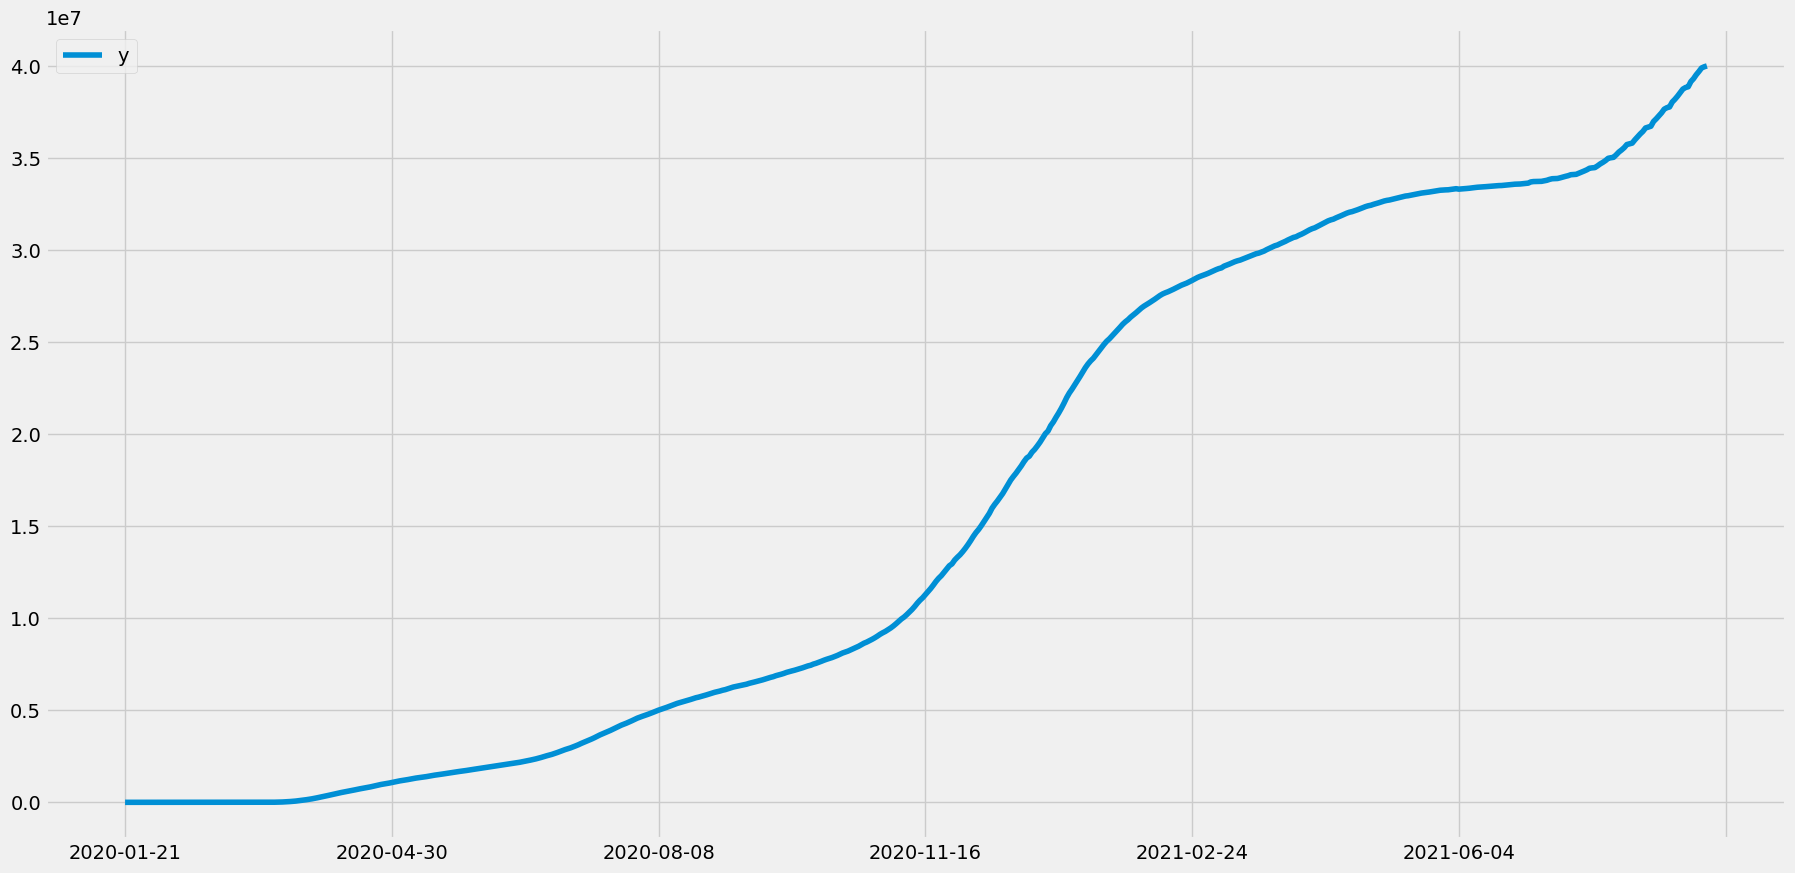

In [7]:
df = pd.read_csv(CFG.data_folder + 'tsdata-1/us_covid.csv')
df.head(10)


# Prophet does have a quirk: a hardcoded format for the input time series - it must consist of a date column named 'ds' (dataframe index or an actual column) and column 'y', where the actual values of the time series are stored
xdat = df[['date', 'cases']].rename(columns={"date": "ds", "cases": "y"}) # Usar rename para poder cambiar los nombres de columnas a los que se necesitan para usar prophet
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '') # Graficar usando .plot()

13:27:06 - cmdstanpy - INFO - Chain [1] start processing
13:27:06 - cmdstanpy - INFO - Chain [1] done processing


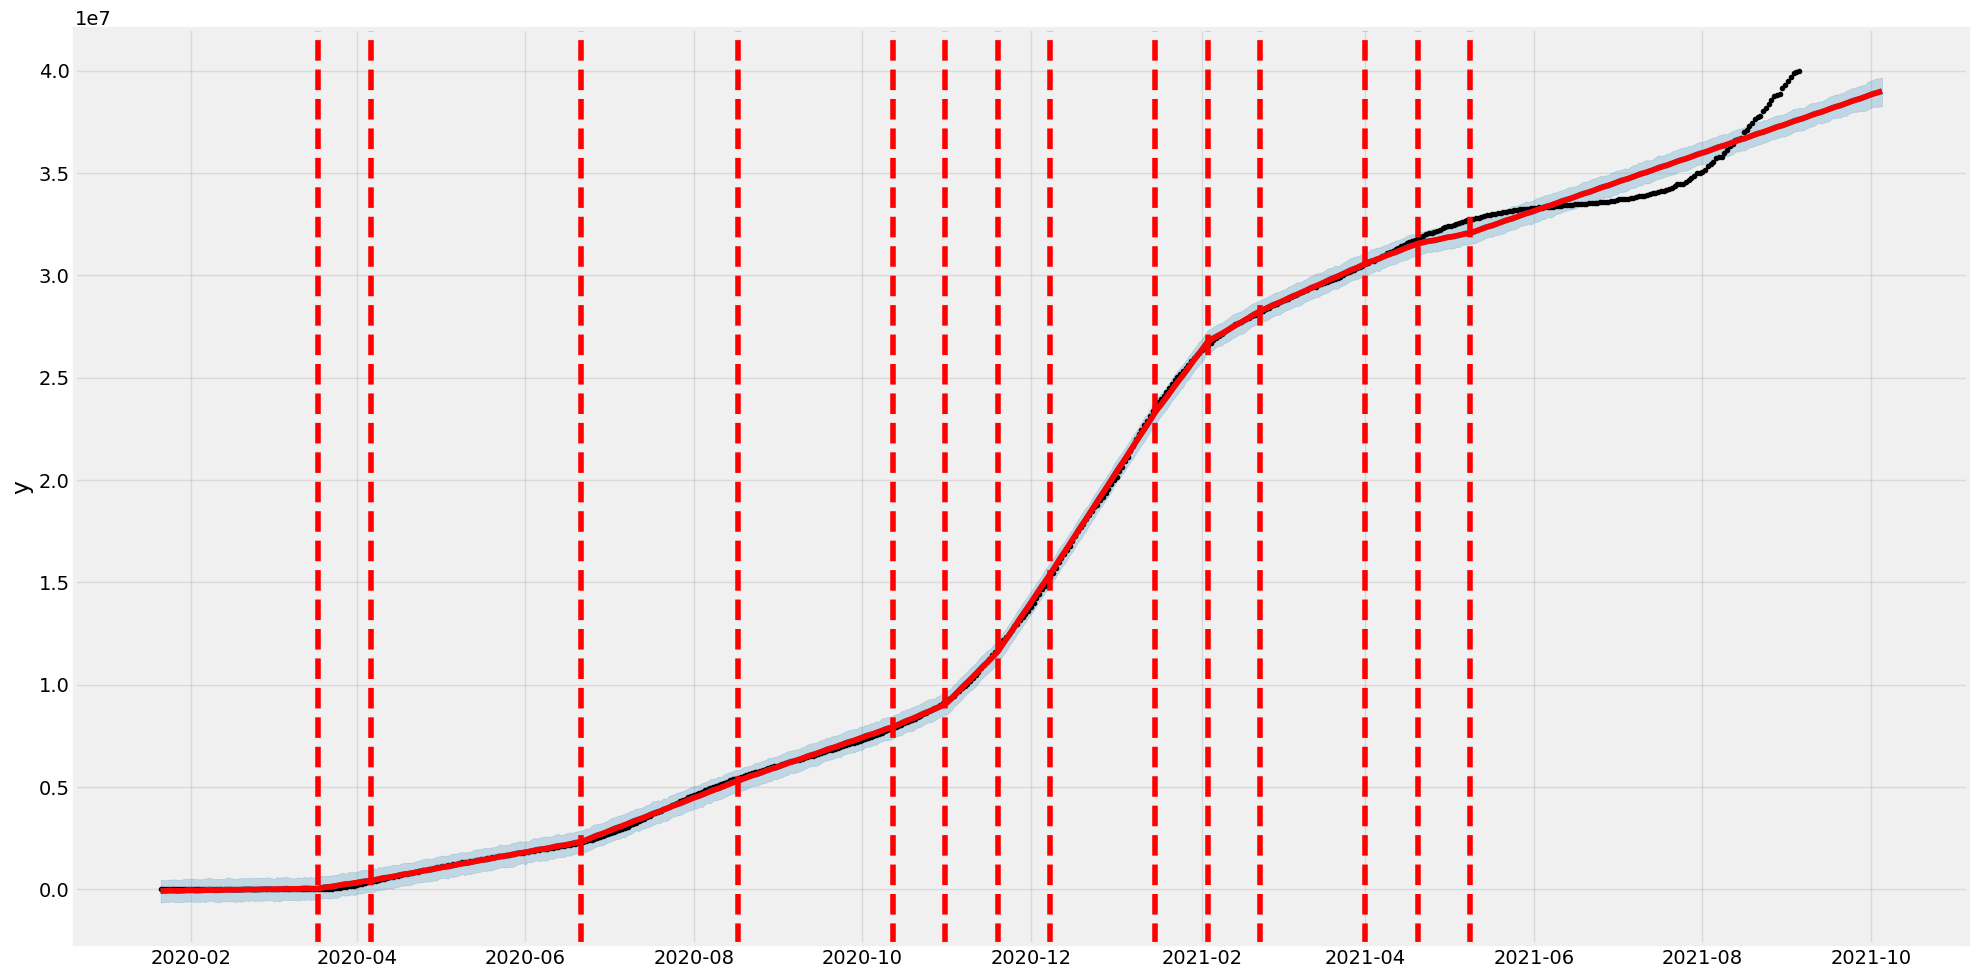

In [8]:
# automatic detection of changepoints
m = Prophet() # Crear un objeto Prophet
m.fit(xdat) # Realizar un fit usando prophet de la base de datos xdat
future = m.make_future_dataframe(periods= 30) # El metodo make_future_dataframe simula la tendencia usando extrapolacion del modelo generador de datos, periods indica el numero de datos a pronosticar
forecast = m.predict(future) # Para poder generar el pronostico se necesita usar el metodo predict. porque make_future_dataframe solamente genera las fechas que se requieren
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '') # Graficar
a = add_changepoints_to_plot(fig.gca(), m, forecast) # add_changepoints_to_plot anade puntos en donde la tasa de crecimiento de la serie de tiempo cambia significativamente.

It seems like the default settings are on the generous side when it comes to assigning changepoints - we can control this behavior by enforcing more regularization. This is achieved by shrinking the changepoint_prior_scale parameter:

13:27:06 - cmdstanpy - INFO - Chain [1] start processing
13:27:06 - cmdstanpy - INFO - Chain [1] done processing


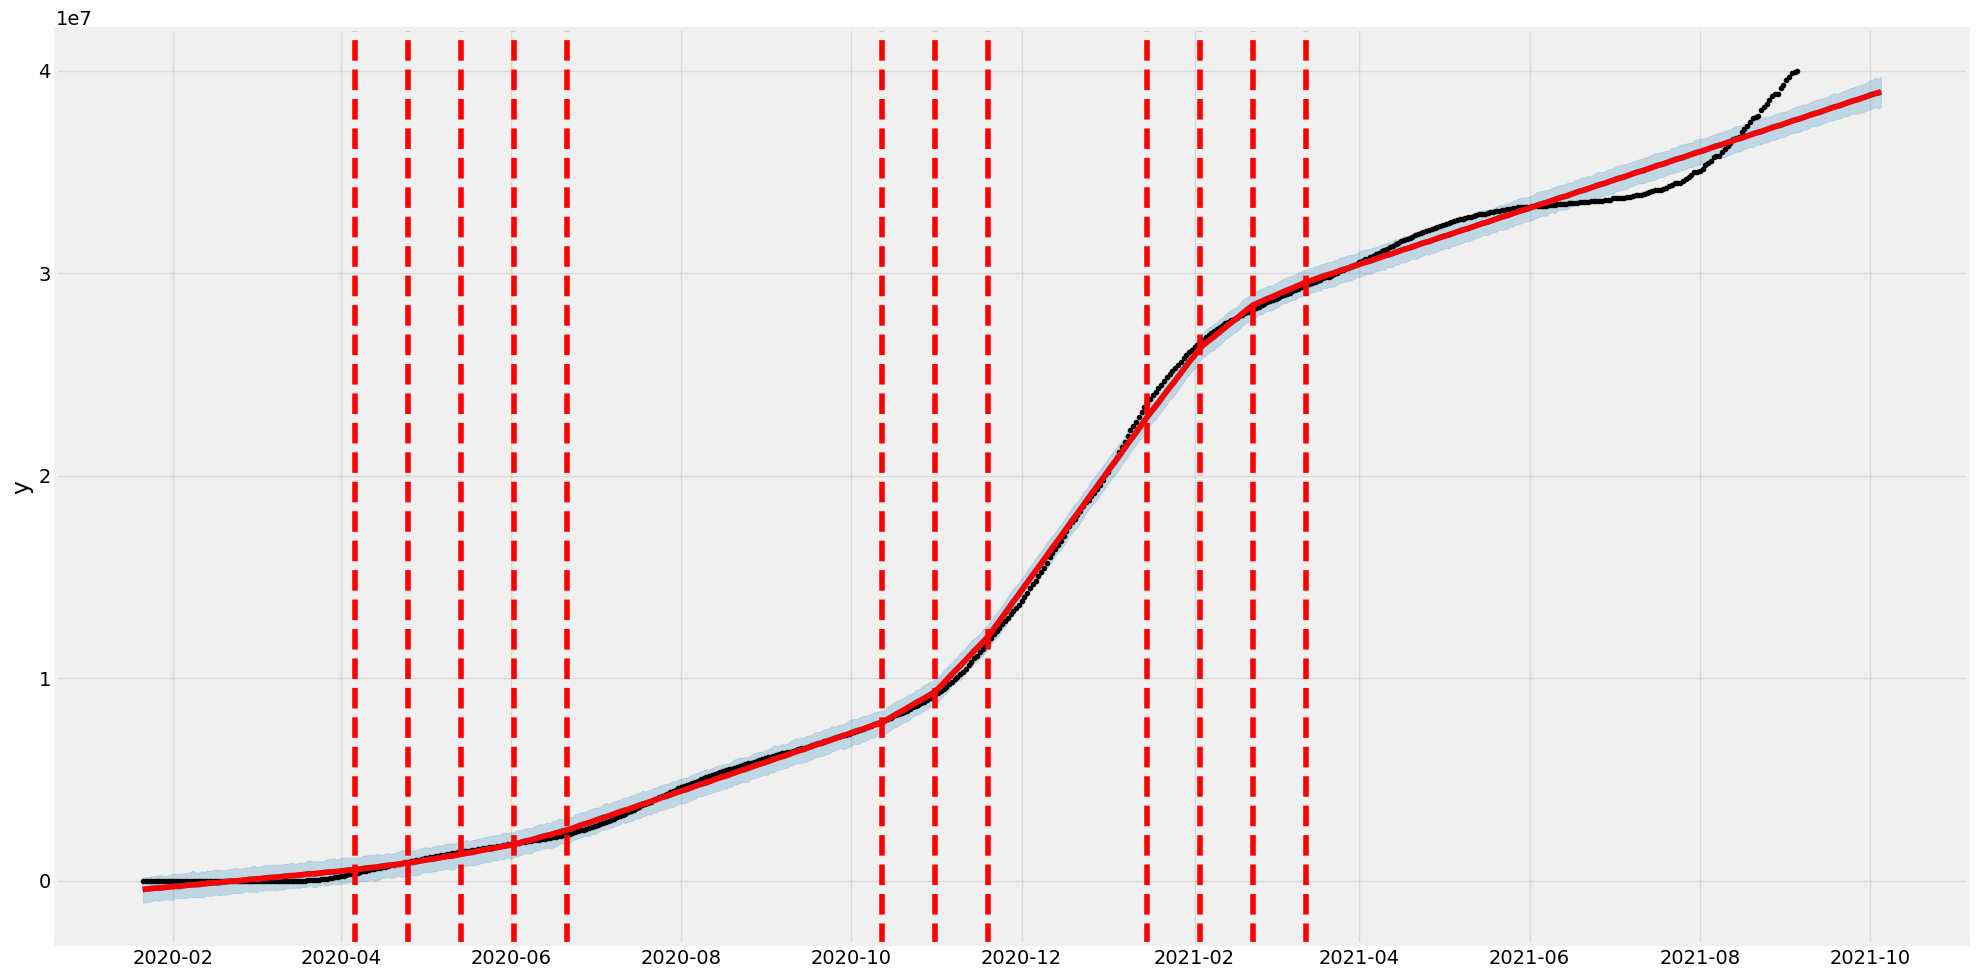

In [9]:
m = Prophet(changepoint_prior_scale = 0.01)
m.fit(xdat)
future = m.make_future_dataframe(periods= 30)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
a = add_changepoints_to_plot(fig.gca(), m, forecast)

## Nonlinear growth 

The first one is called Nonlinear, Saturating Growth. It is represented in the form of the logistic growth model:
    
\begin{equation}
T(t) = \frac{C}{1 + exp(-k(t-m))}
\end{equation}

where $C$ is the carrying capacity (maximum value) and $k$ is the growth rate ("steepness" of the trend curve). $C$ and $k$ can be constant or time-varying. This logistic equation allows modelling non-linear growth with saturation, that is when the growth rate of a value decreases with its growth. Prophet supports both automatic and manual tuning of their variability. The library can itself choose optimal points of trend changes by fitting the supplied historical data.

Sticking with the theme that has dominated everybody's life from 2020, we will use data on Covid-19 cases in China.

<Axes: >

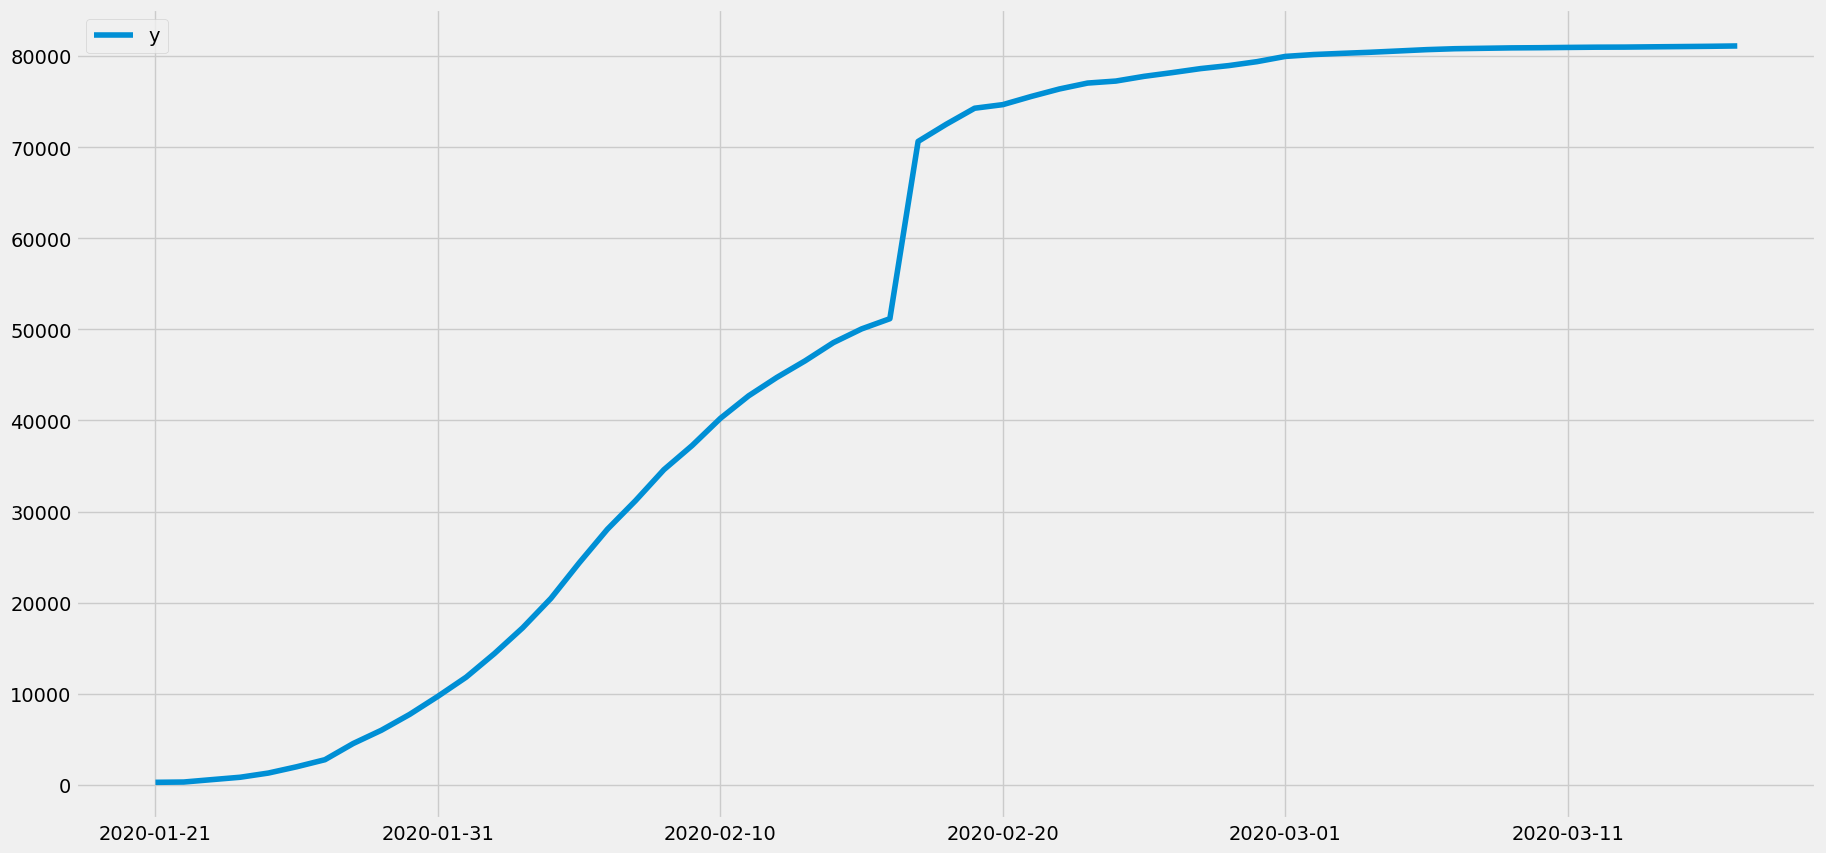

In [10]:
df = pd.read_csv(CFG.data_folder + 'who-cases-dataset-and-wdi-country-population/WHO_full_data2003.csv')
# La siguiente linea realiza en orden: 1) encuentra los datos cuya locacion sea china usando df.loc[], posteriormente selecciona solamente las columnas 'date' y 'total_cases' , y luego
# renombra las columnas como ds y y, que se requieren para prophet
df = df.loc[df['location'] == 'China'][['date', 'total_cases']].rename(columns={"date": "ds", "total_cases": "y"})
df.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '') # Grafica de la base de datos

We can see the curve flatlining somewhat - in Prophet we can incorporate such knowledge into the model by setting a cap (an upper limit on the forecast value):

13:27:07 - cmdstanpy - INFO - Chain [1] start processing
13:27:08 - cmdstanpy - INFO - Chain [1] done processing


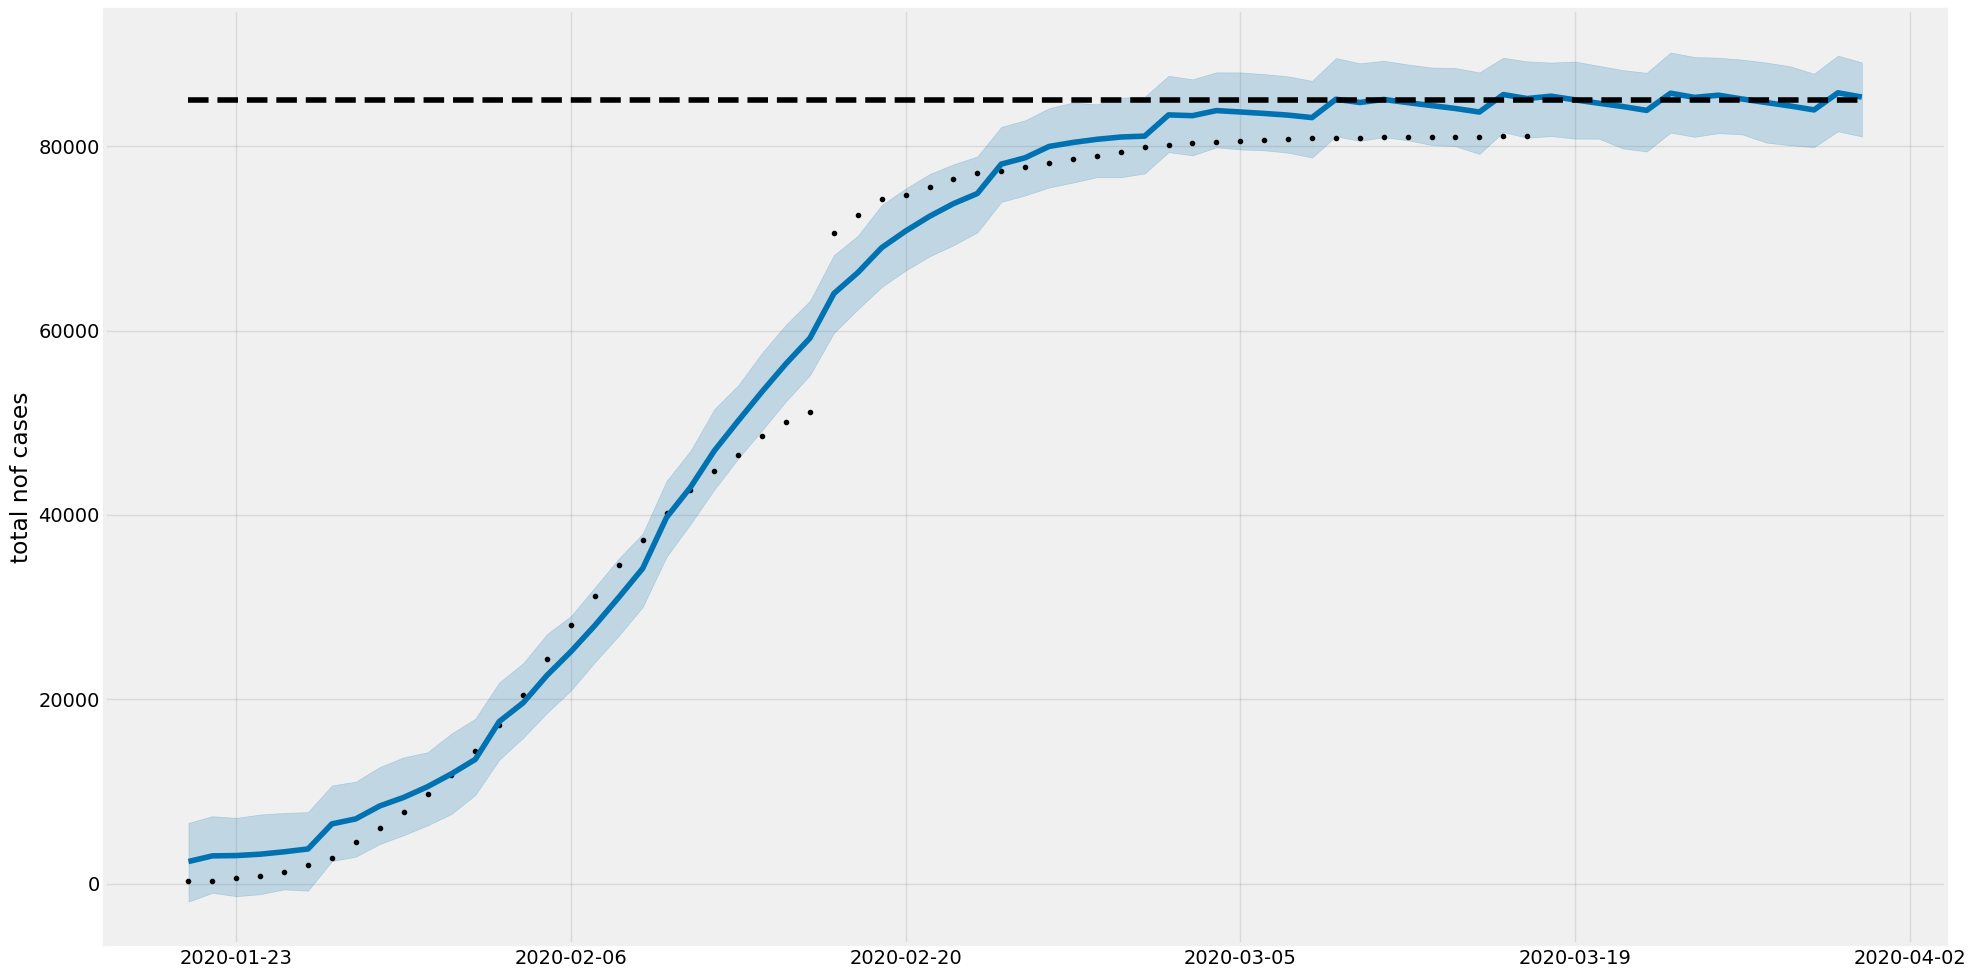

In [11]:
# add the cap to the model
df['cap'] = 85000 # anadir columna para cap
# fit the model
m = Prophet(growth='logistic') # crecimiento logistico, no lineal
m.fit(df) # fit de la base de datos usando prophet
# prediction
future = m.make_future_dataframe(periods= 14) # 14 predicciones en el futuro, igualmente necesitaremos usar .predict()
future['cap'] = 85000

# plot the results
fcst = m.predict(future)
fig = m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total nof cases')

The approach is symmetrics, i.e. we can limit the series from below as well (contrived as it might seem in this particular application ;-)

13:27:08 - cmdstanpy - INFO - Chain [1] start processing
13:27:08 - cmdstanpy - INFO - Chain [1] done processing


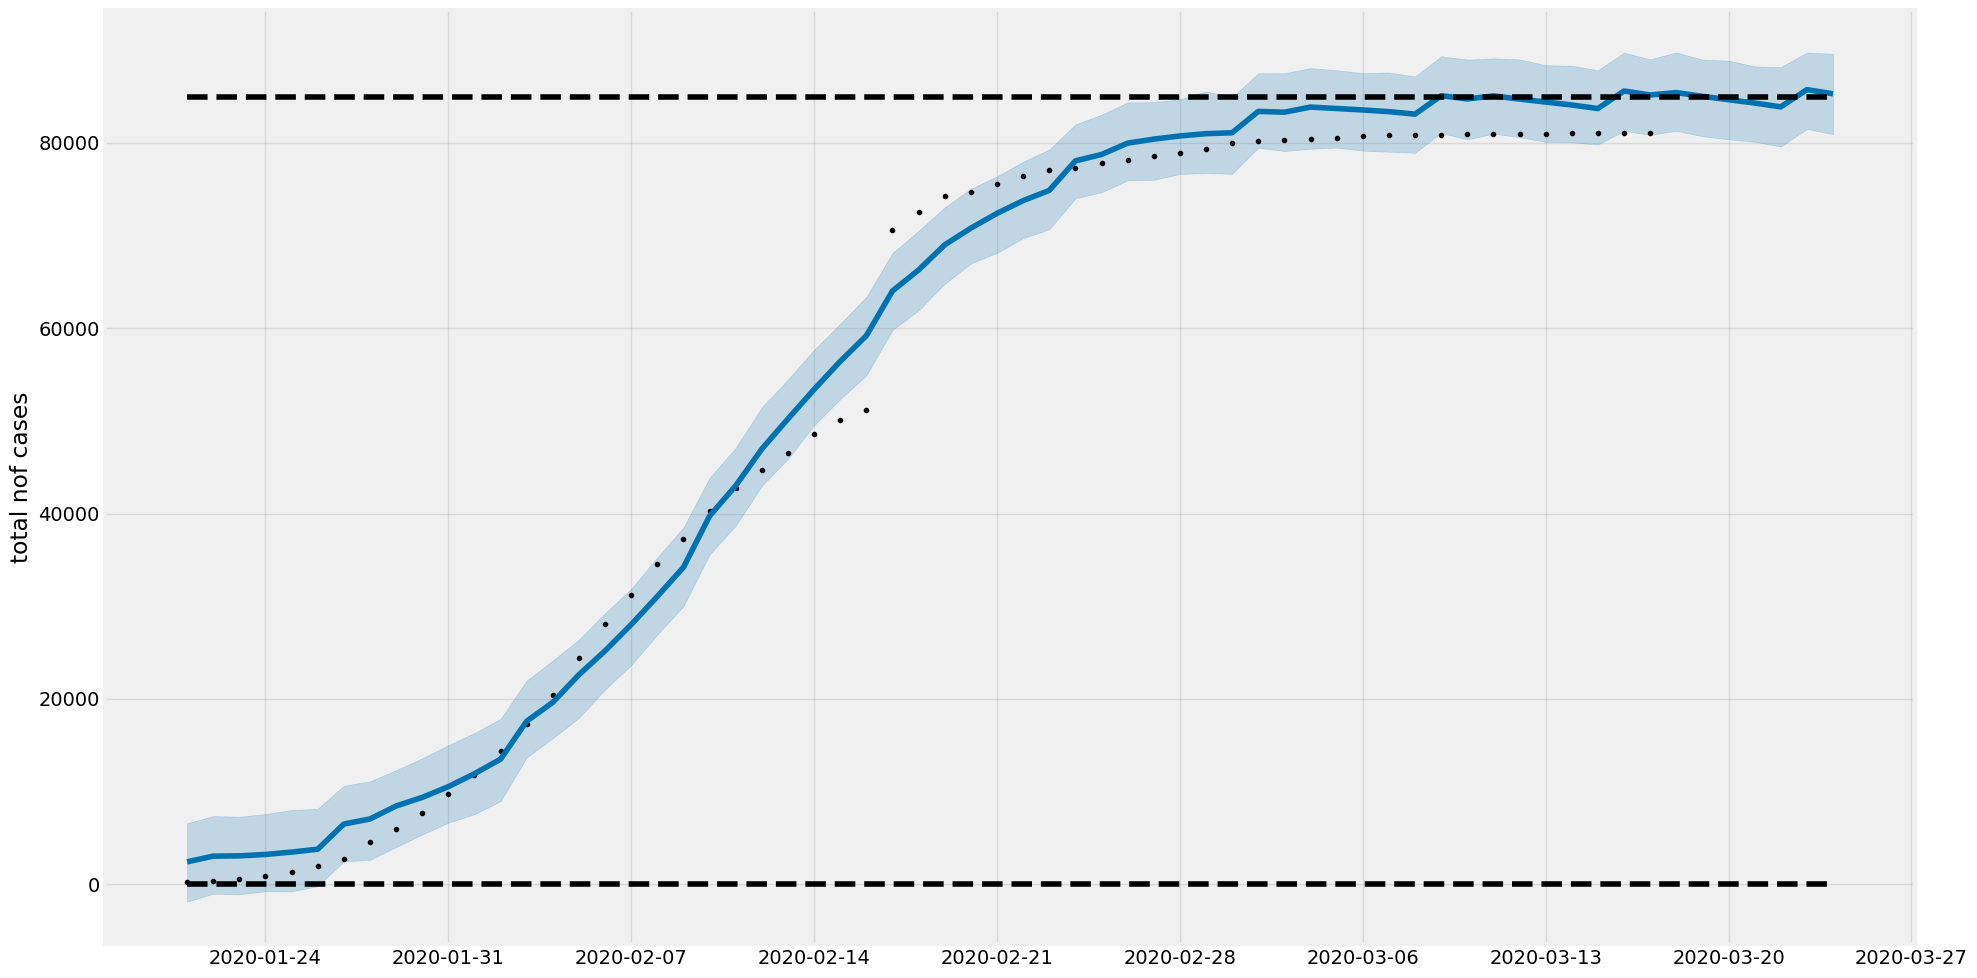

In [12]:
# set the upper & lower limit for the forecast
df['cap'] = 85000
df['floor'] = 0

# fit a model
m = Prophet(growth='logistic')
m.fit(df)

# predict
future = m.make_future_dataframe(periods= 7)
future['cap'] = 85000
future['floor'] = 0
fcst = m.predict(future)

m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total nof cases')
print()

# Seasonality
​
When dealing with data in practical applications, it is frequently necessary to take into account multiple seasonal patterns occurring in parallel; a classic example would be data related to energy consumption: there are morning vs evening patterns (intraday), workdays vs weekend (weekly) and during the year (annual). Modeling them explicitly tends to be cumbersome (you need to add more equations in exponential smoothing or introduce dummies in ARIMA), which is one of the issues Prophet was designed to overcome. The core of the underlying logic is a the Fourier expansion:
    
\begin{equation}
    S(t) = \sum_{i=1}^N \left(a_n cos\left(\frac{2\pi i t}{P} \right) + b_n sin\left(\frac{2 \pi i t}{P} \right) \right)
\end{equation}
​
Unpacking this formula: 
​
* `sin` and `cos` function form an orthogonal basis 
* this means that every function can be represented as a combination as in the equation defined above - recall that in the GAM setup we treat time as the only regressor, so a time series can be viewed as a function of time $S(t)$ 
* by cutting off the expansion for a certain $N$ we can remove high frequency oscillations $\rightarrow$ low pass filter


In [13]:
df = pd.read_csv(CFG.data_folder + 'hourly-energy-consumption/pjm_hourly_est.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.head(5)

,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
0,1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1,1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
2,1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
3,1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
4,1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0


Prophet is built for univariate data, so we will pick one series. Notice that we are using hourly data, which we will progressively aggregate to lower frequencies to demonstrate the out-of-the-box functionality that Prophet provides.

<Axes: xlabel='ds'>

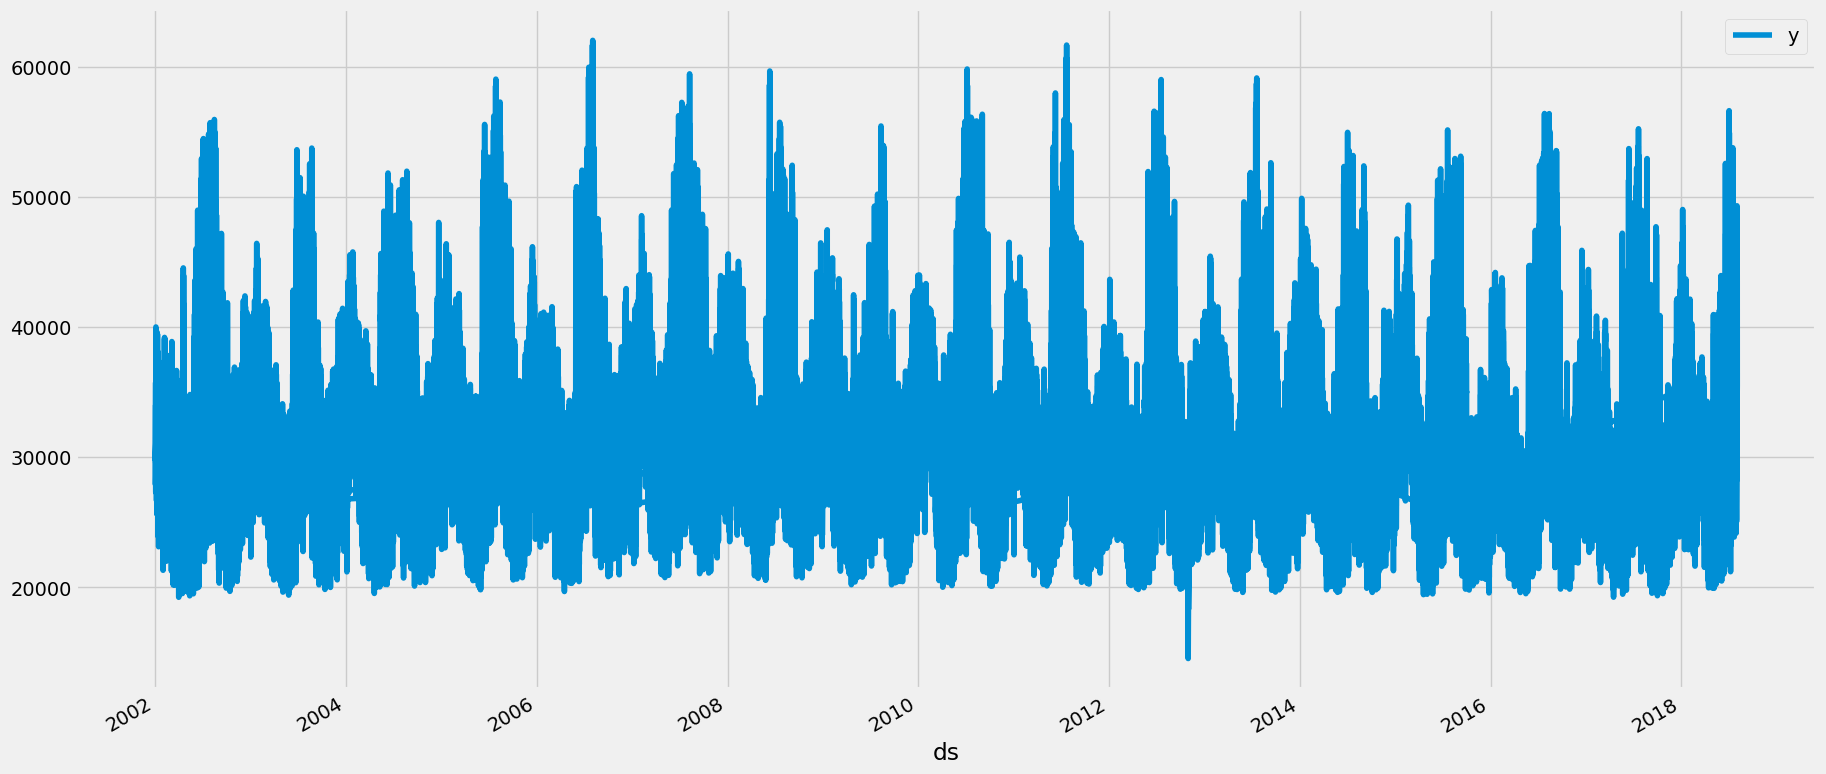

In [14]:
xdat = df[['Datetime', 'PJME']] # Solamente conservar Datetime y PJME
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0] # Hallar el primer x donde hay algun valor en PJME, es decir que no es NA
xdat = xdat.loc[first_valid:].rename(columns={"Datetime": "ds", "PJME": "y"}) 
# con el .loc[] estamos cogiendo desde la fila first_valid hasta el fin (Dado el :), ademas como no se coloca de manera explicita las columnas, se seleccionan todas.
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2)) # Graficar

13:27:13 - cmdstanpy - INFO - Chain [1] start processing
13:27:43 - cmdstanpy - INFO - Chain [1] done processing


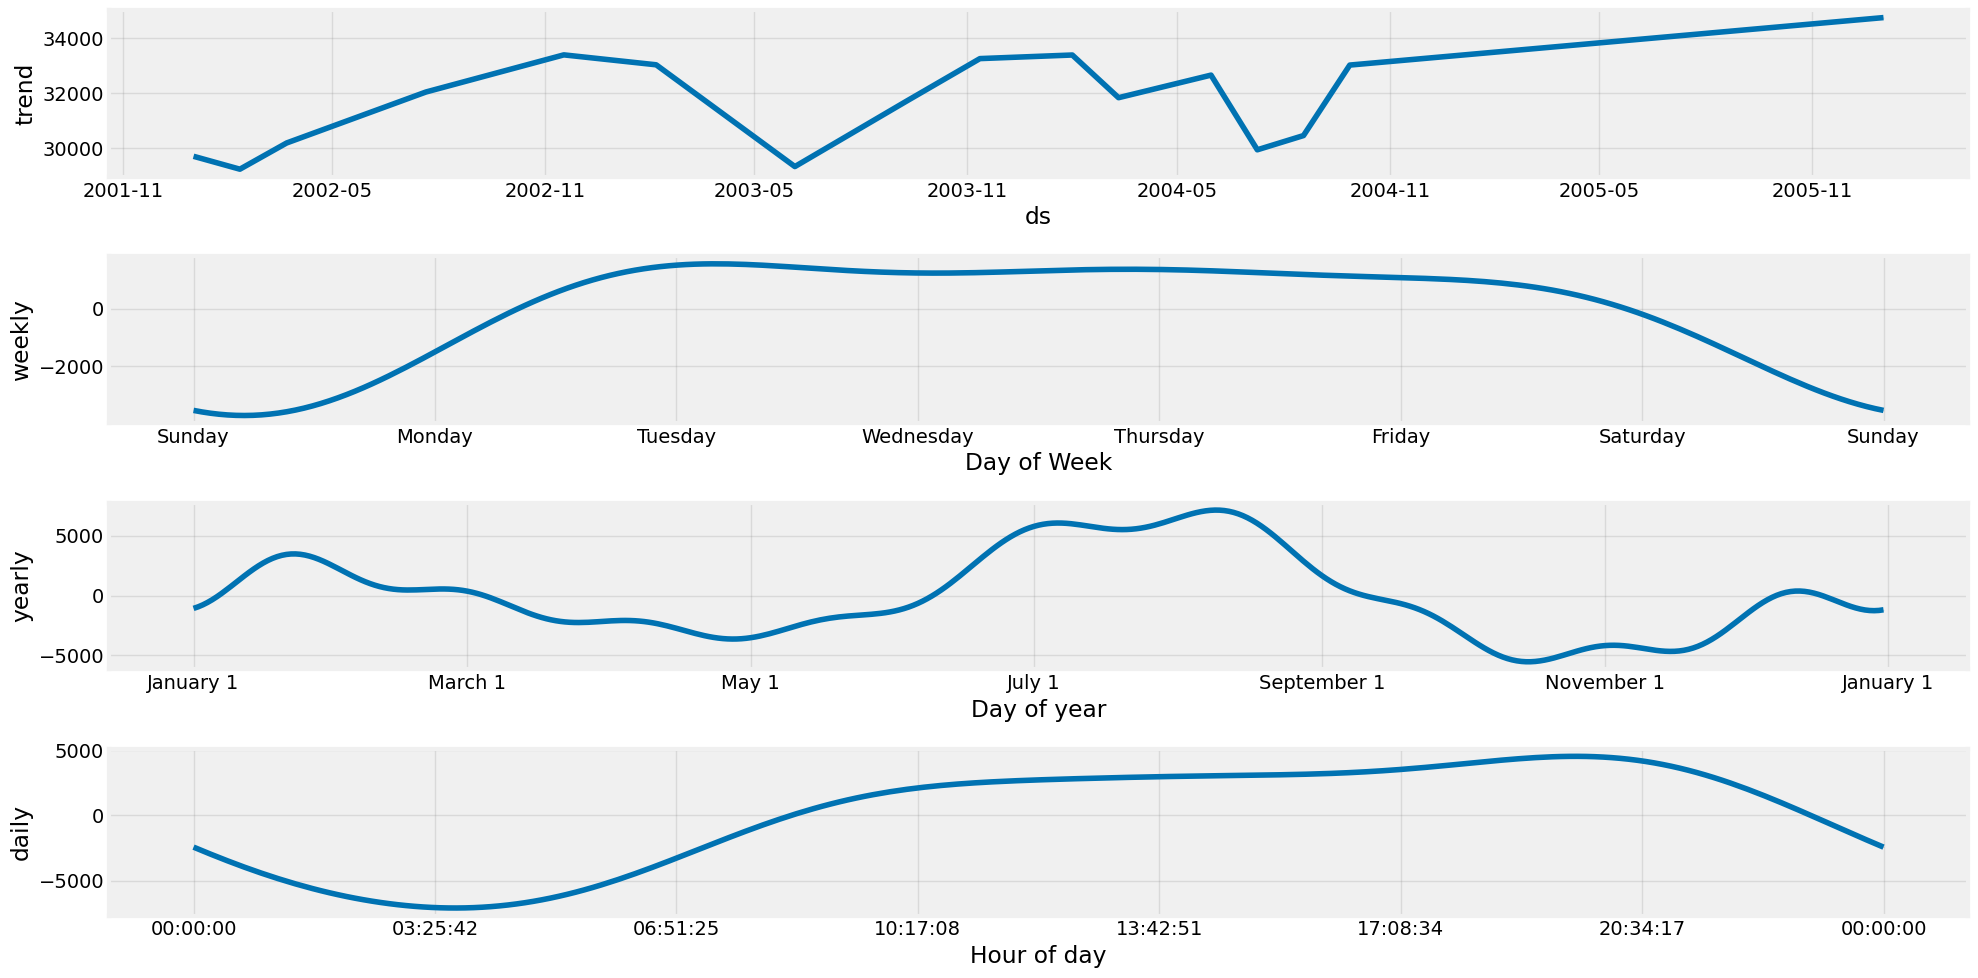

In [15]:
# we reduce the dataset size for speed - the only requirement while doing is to keep at least two complete cycles 
# for each seasonality we intend to fit 
m = Prophet().fit(xdat.iloc[:30000]) # iloc[] es como loc, en tanto que selecciona parte del df
future = m.make_future_dataframe(periods = 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

If we are using data sampled at higher frequency than daily, a daily seasonal pattern is automatically fitted. What if we aggregate the data to daily frequency?


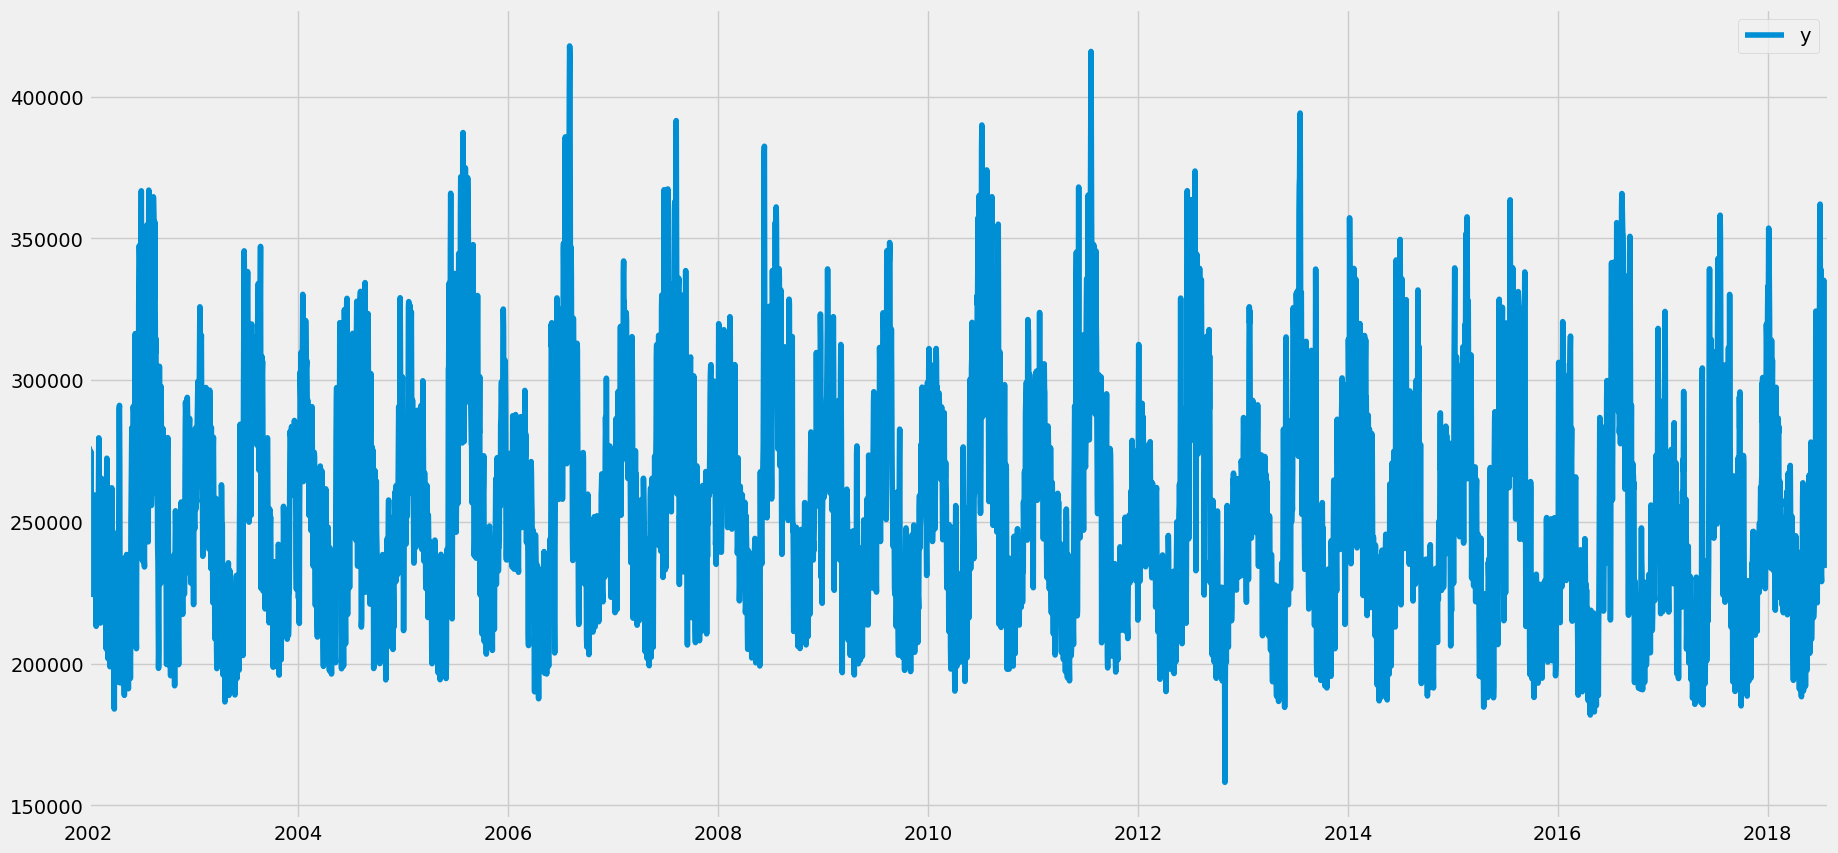

In [16]:
xdat = df.resample('D', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={"Datetime": "ds", "PJME": "y"}) # se utiliza .resample para agregarlo a frecuencia diaria
xdat['y'] /= 10^9
# we purge the leading zeros, along with the last observation - we only have a few hours of the last day in the sample => incomplete day
ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '')
print()

13:27:48 - cmdstanpy - INFO - Chain [1] start processing
13:27:49 - cmdstanpy - INFO - Chain [1] done processing


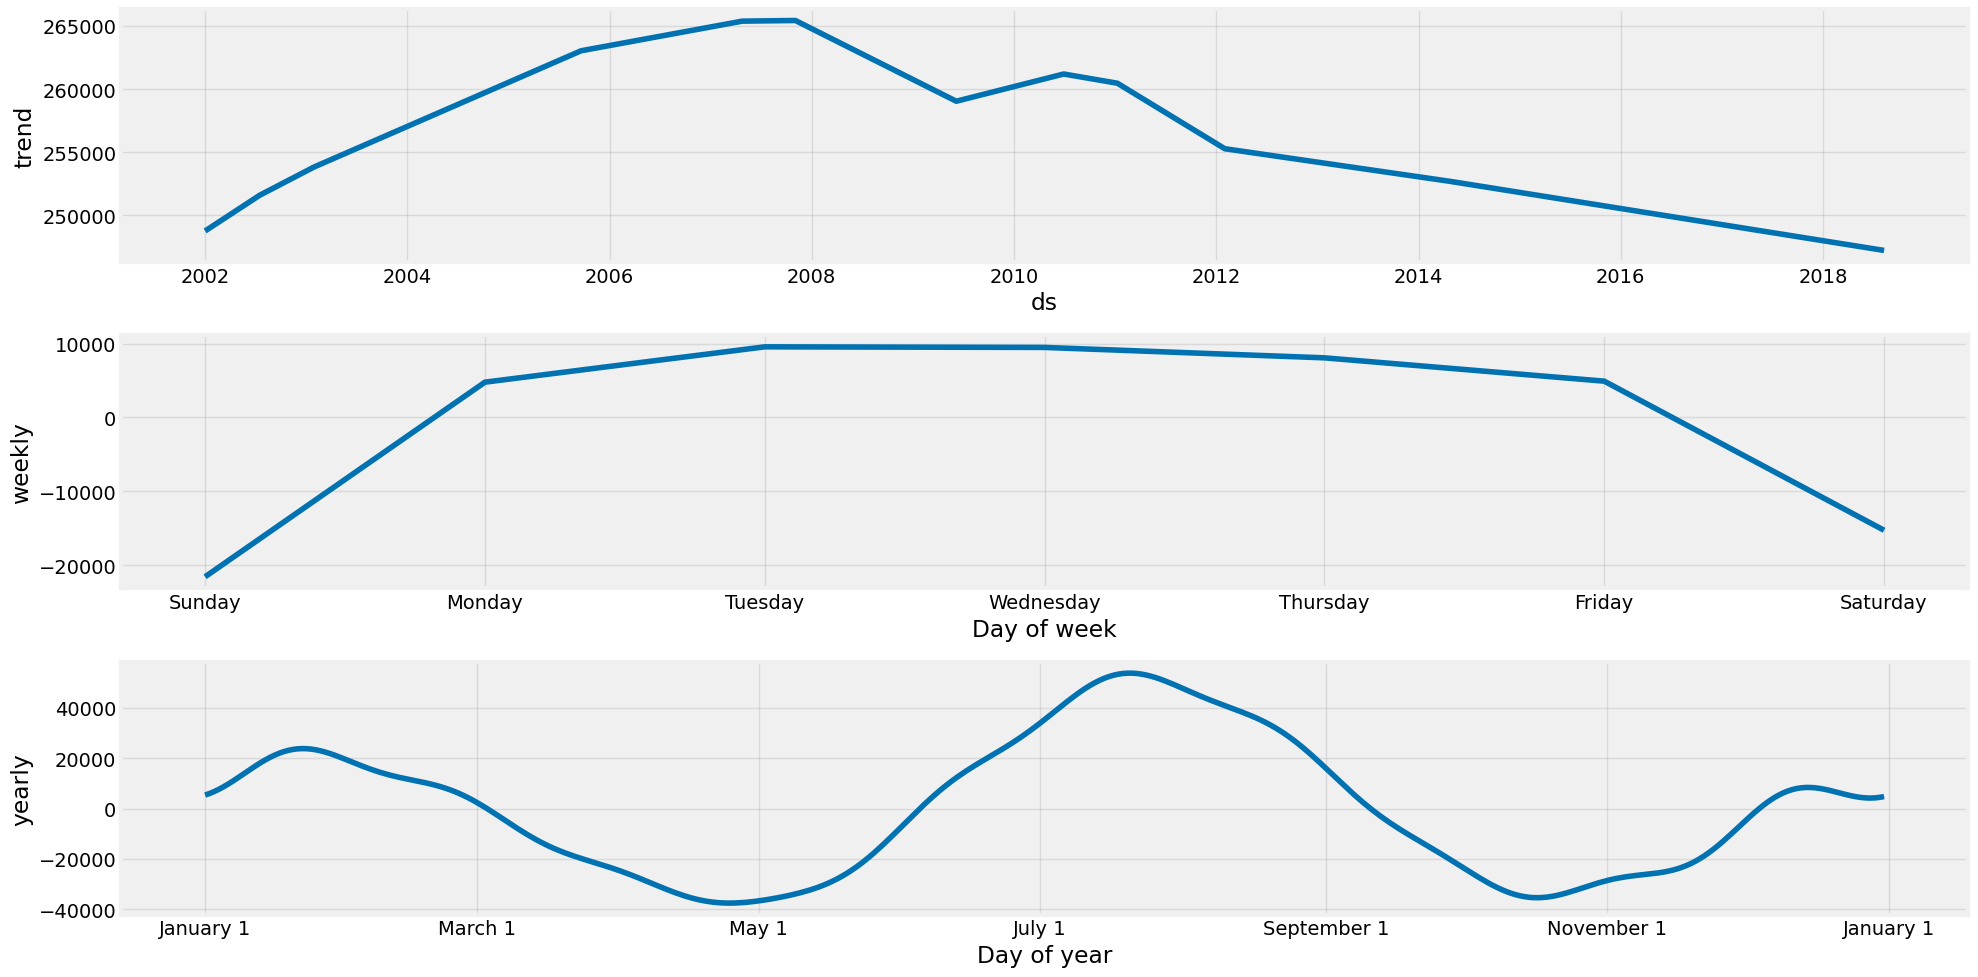

In [17]:
# we proceed in a similar manner as before
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 7, freq = 'D')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

The same logic applies if we downsample the data further:

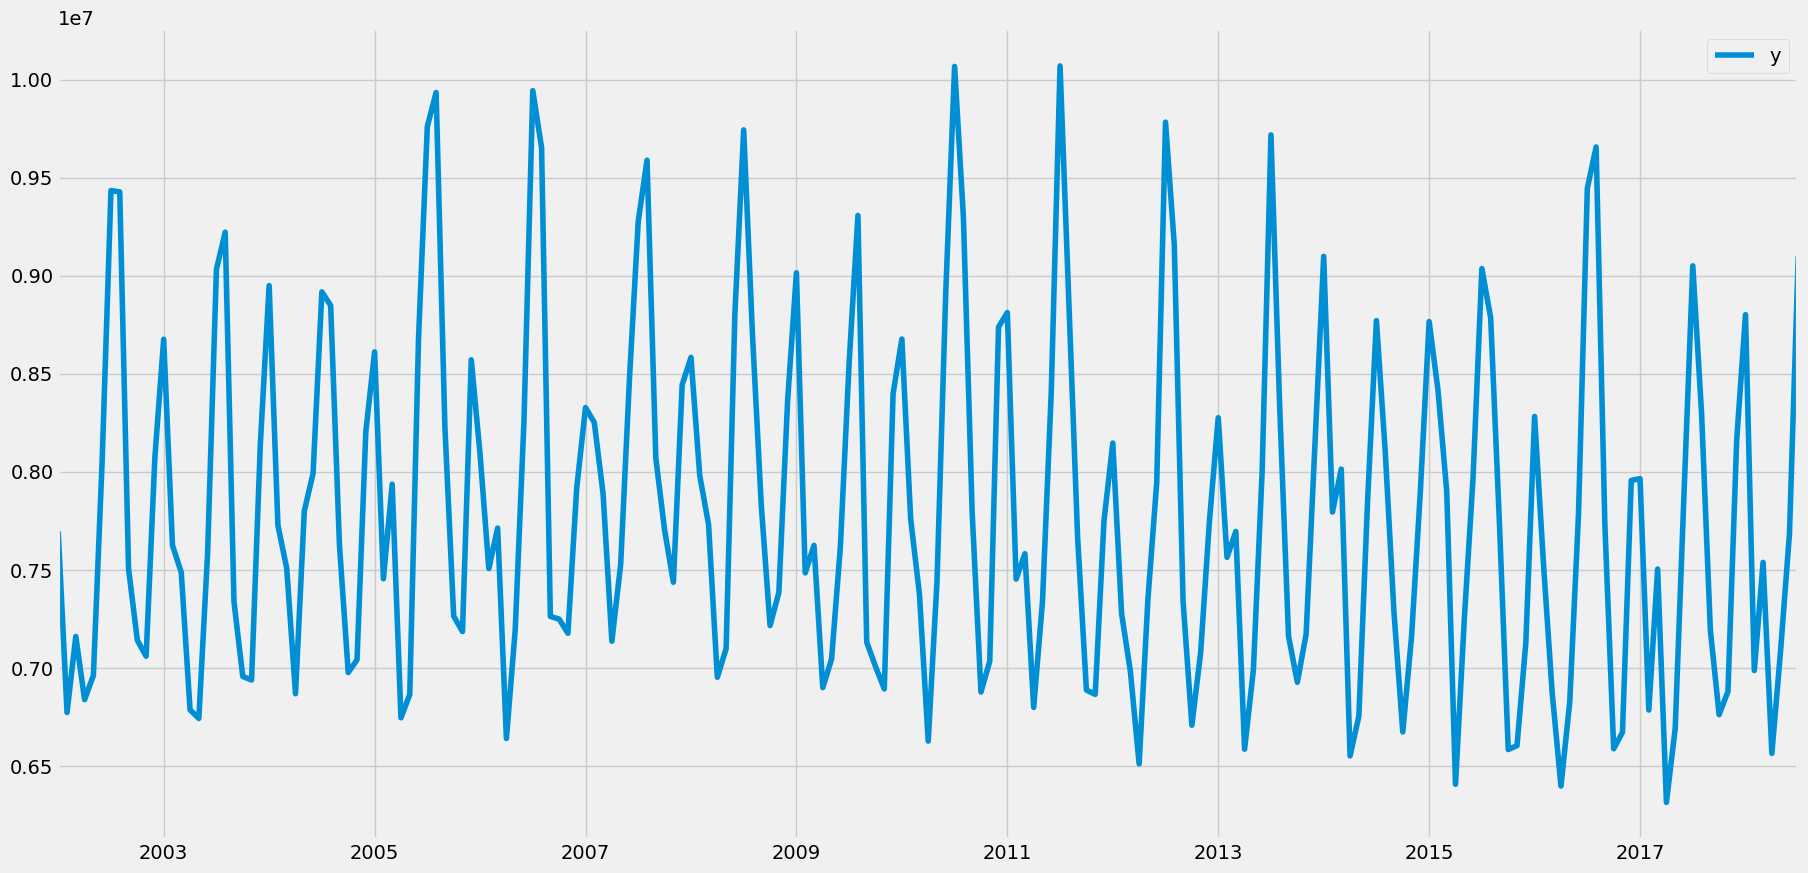

In [18]:
xdat = df.resample('M', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat['y'] /= 10^9
# we purge the leading zeros, along with the last observation - we only have a few hours of the last day in the sample => incomplete day
ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '')
print()

13:27:51 - cmdstanpy - INFO - Chain [1] start processing
13:27:51 - cmdstanpy - INFO - Chain [1] done processing


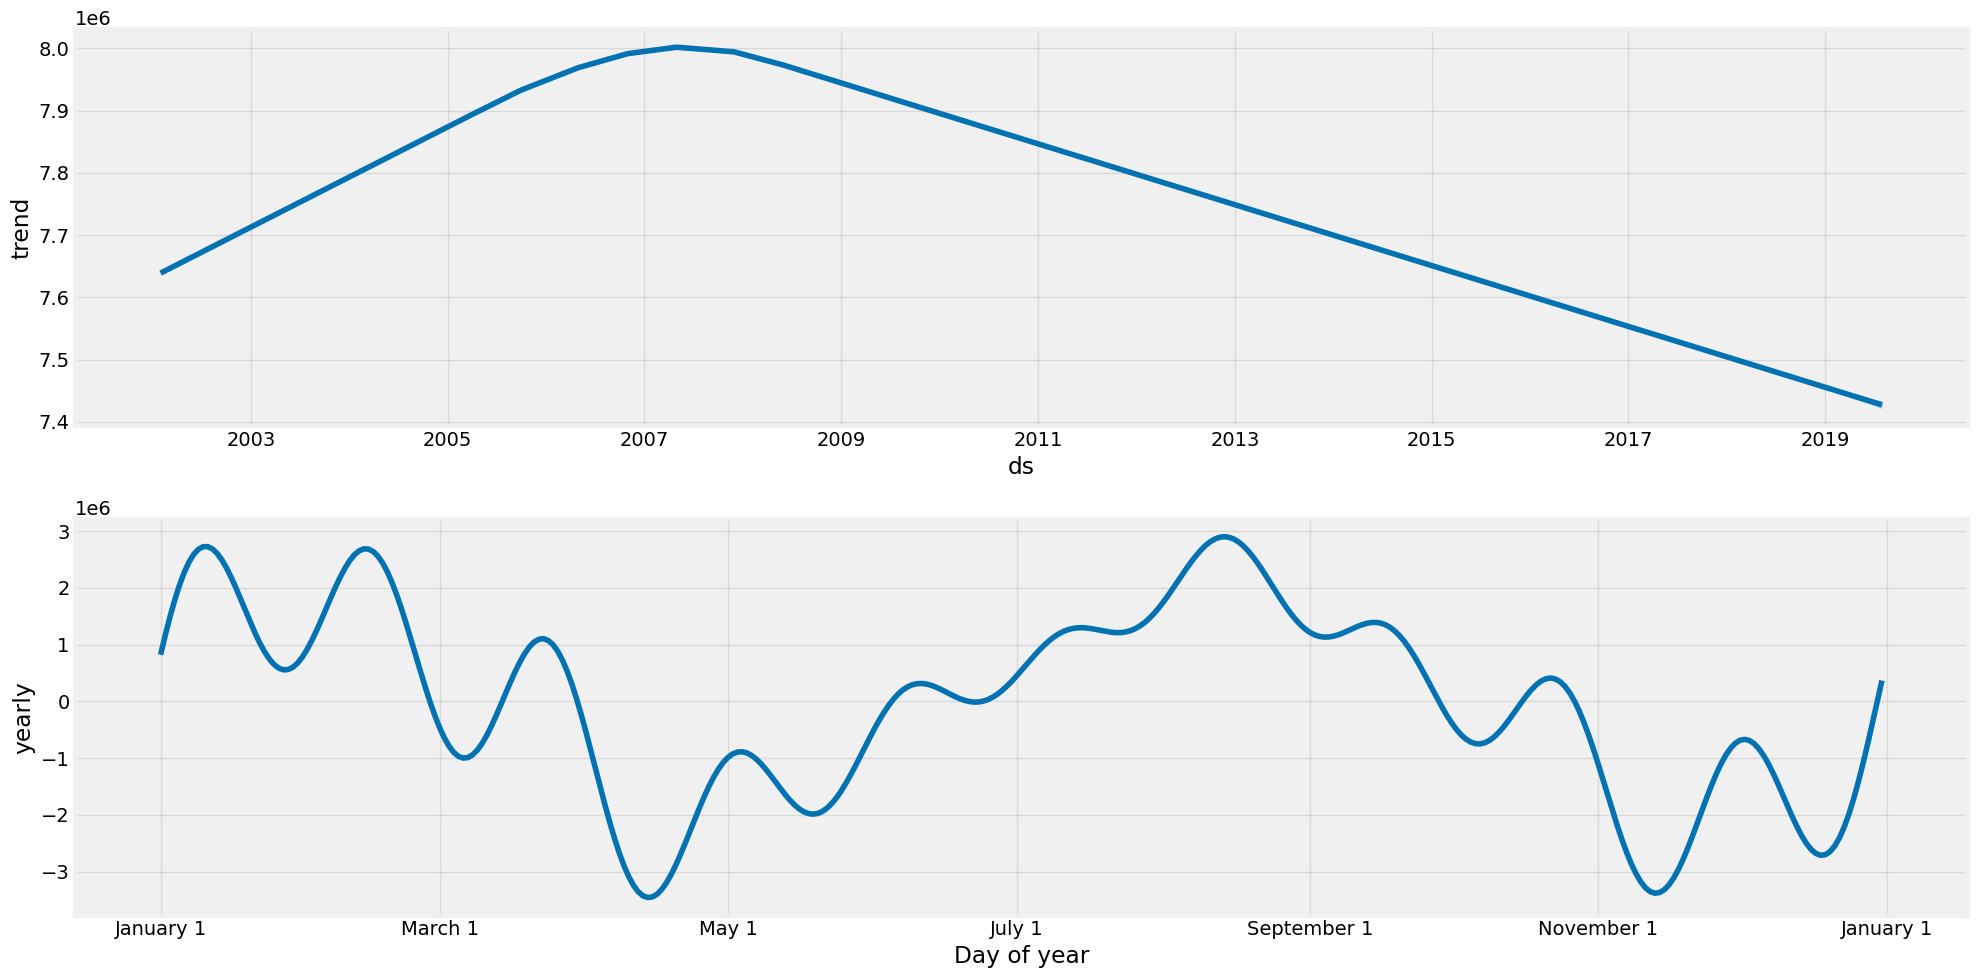

In [19]:
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 12, freq = 'M')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

## Seasonality specification

Apart from deciding on which frequencies to model explicitly, we have more options to setup our Prophet model. First, there is `seasonality_mode` - additive or multiplicative:

13:27:52 - cmdstanpy - INFO - Chain [1] start processing
13:27:52 - cmdstanpy - INFO - Chain [1] done processing


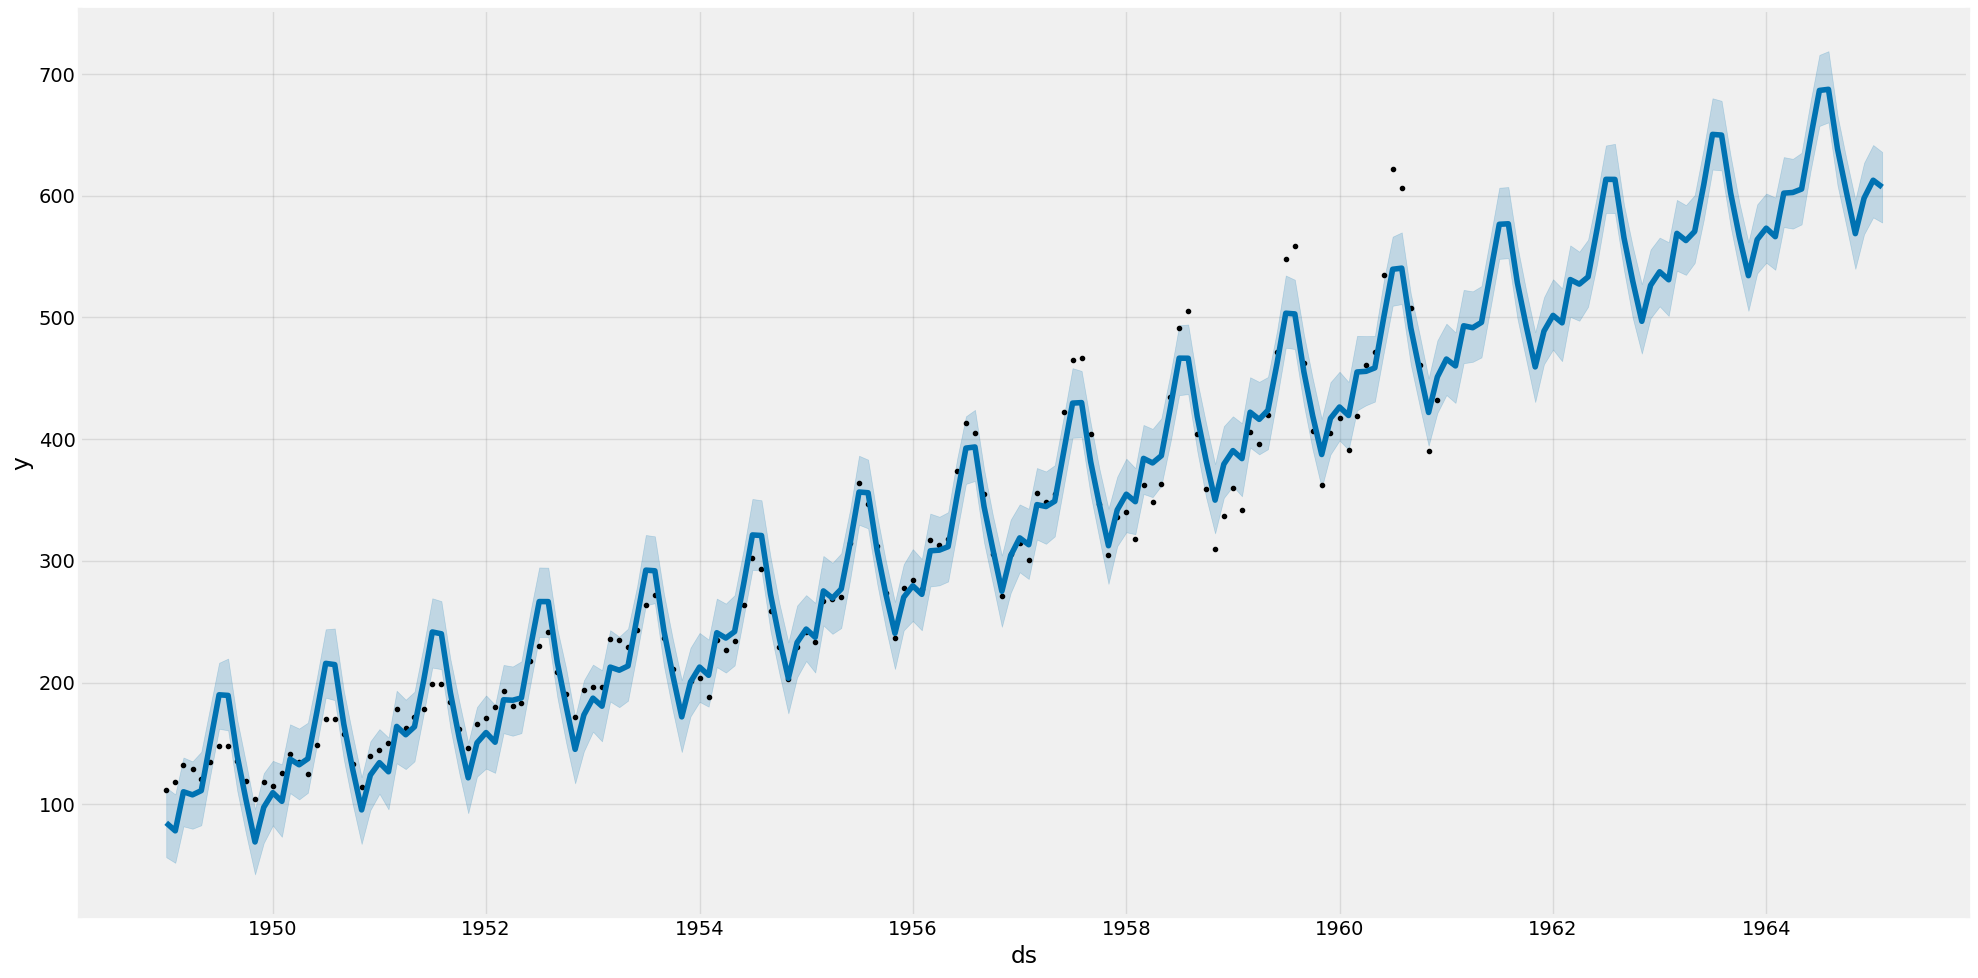

In [20]:
# import inspect ; xlist = inspect.getfullargspec(Prophet); xlist.args
df = pd.read_csv(CFG.data_folder + 'tsdata-1/example_air_passengers.csv')
m = Prophet(seasonality_mode ='additive')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

13:27:52 - cmdstanpy - INFO - Chain [1] start processing
13:27:52 - cmdstanpy - INFO - Chain [1] done processing


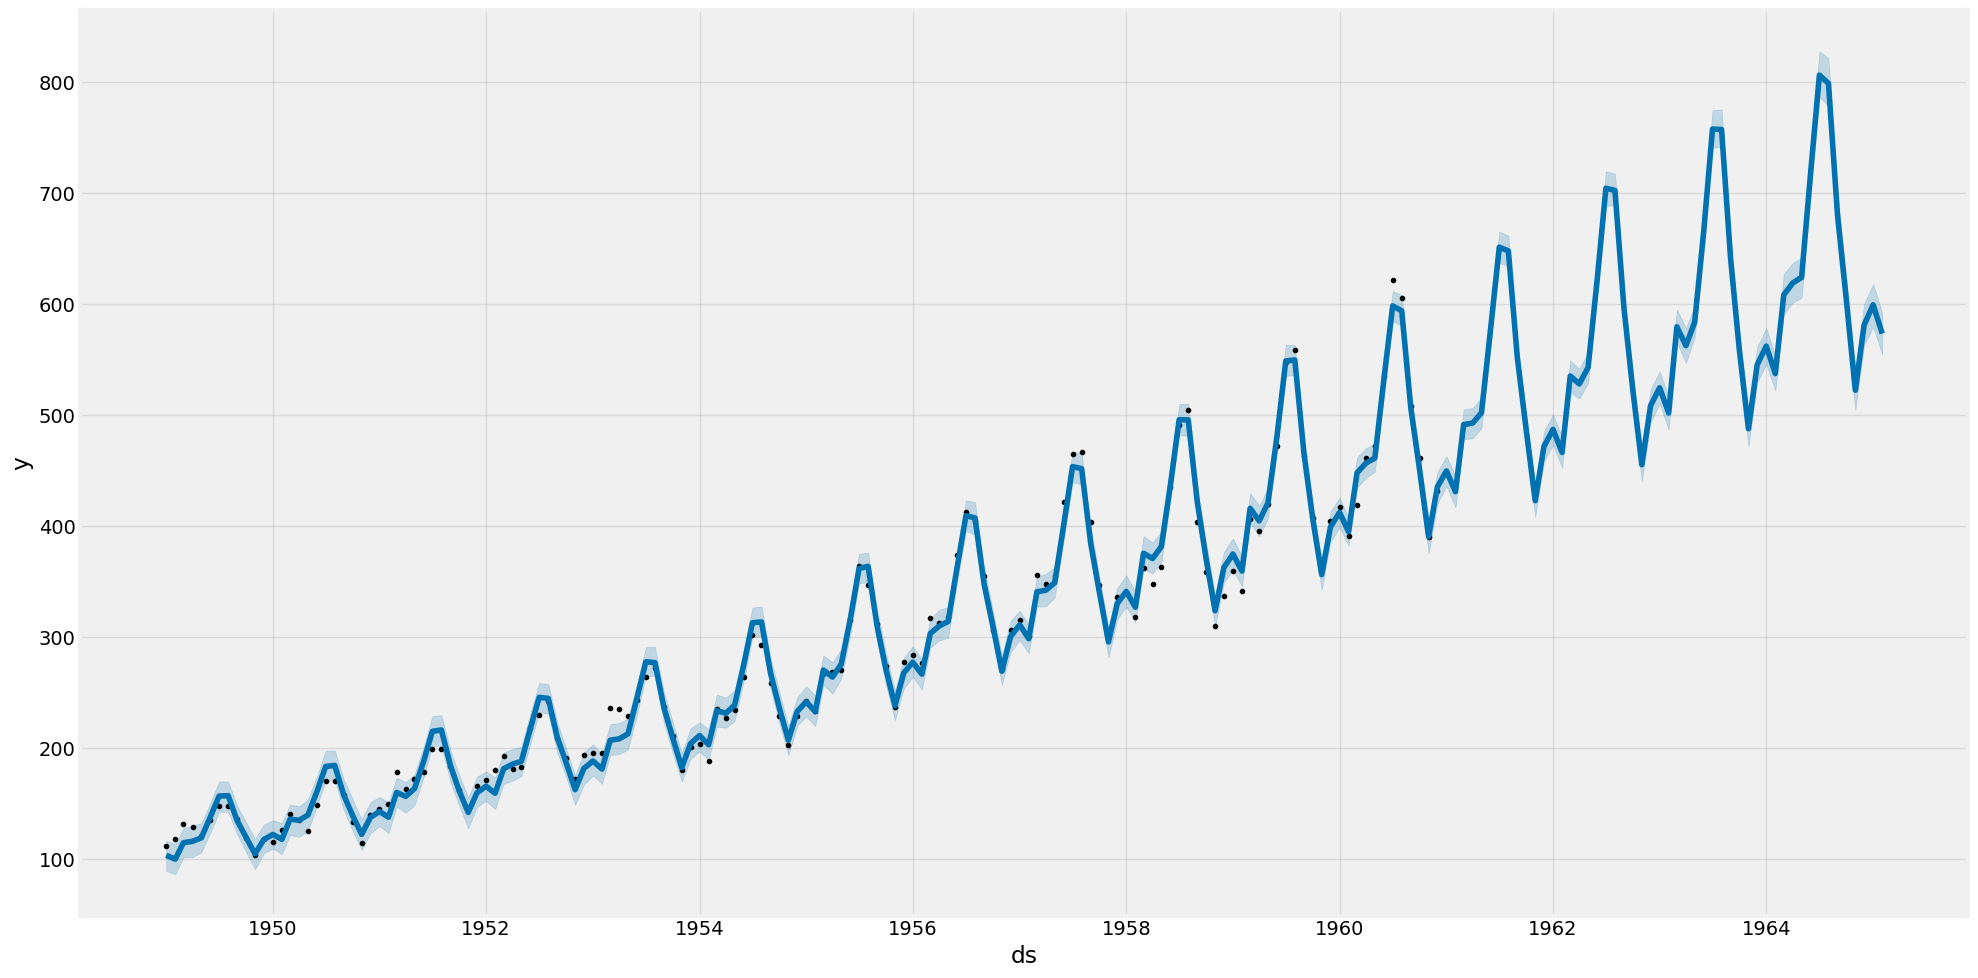

In [21]:
m = Prophet(seasonality_mode ='multiplicative') # modo multiplicativo
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

Depending on the problem at hand, we might want to allow strong effects of the seasonal component on the forecast - or have it reduced. This intuition can be quantified by adjusting the seasonality_prior_scale argument, which imapcts the extent to which the seasonality model will fit the data (remark for those with Bayesian exposure: works pretty much the way a prior would).

13:27:53 - cmdstanpy - INFO - Chain [1] start processing
13:27:53 - cmdstanpy - INFO - Chain [1] done processing


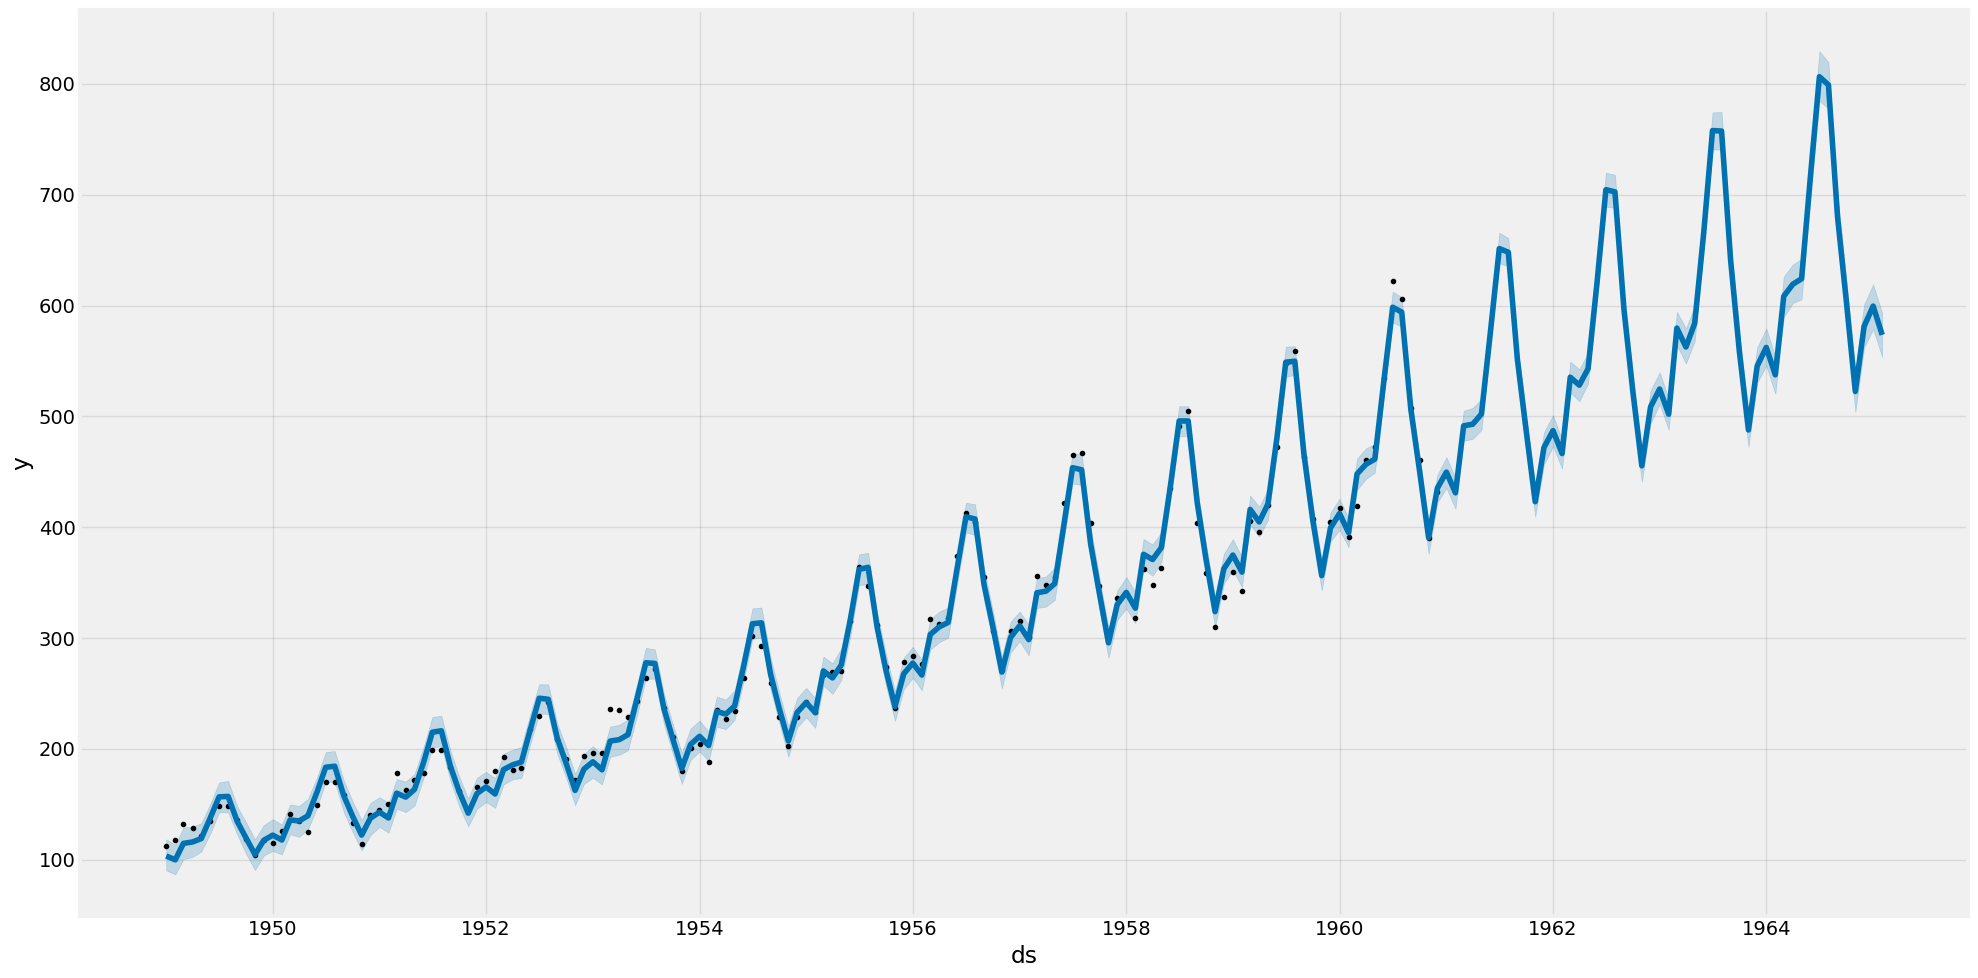

In [22]:
# we keep the default value
m = Prophet(seasonality_mode ='multiplicative')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

13:27:53 - cmdstanpy - INFO - Chain [1] start processing
13:27:53 - cmdstanpy - INFO - Chain [1] done processing


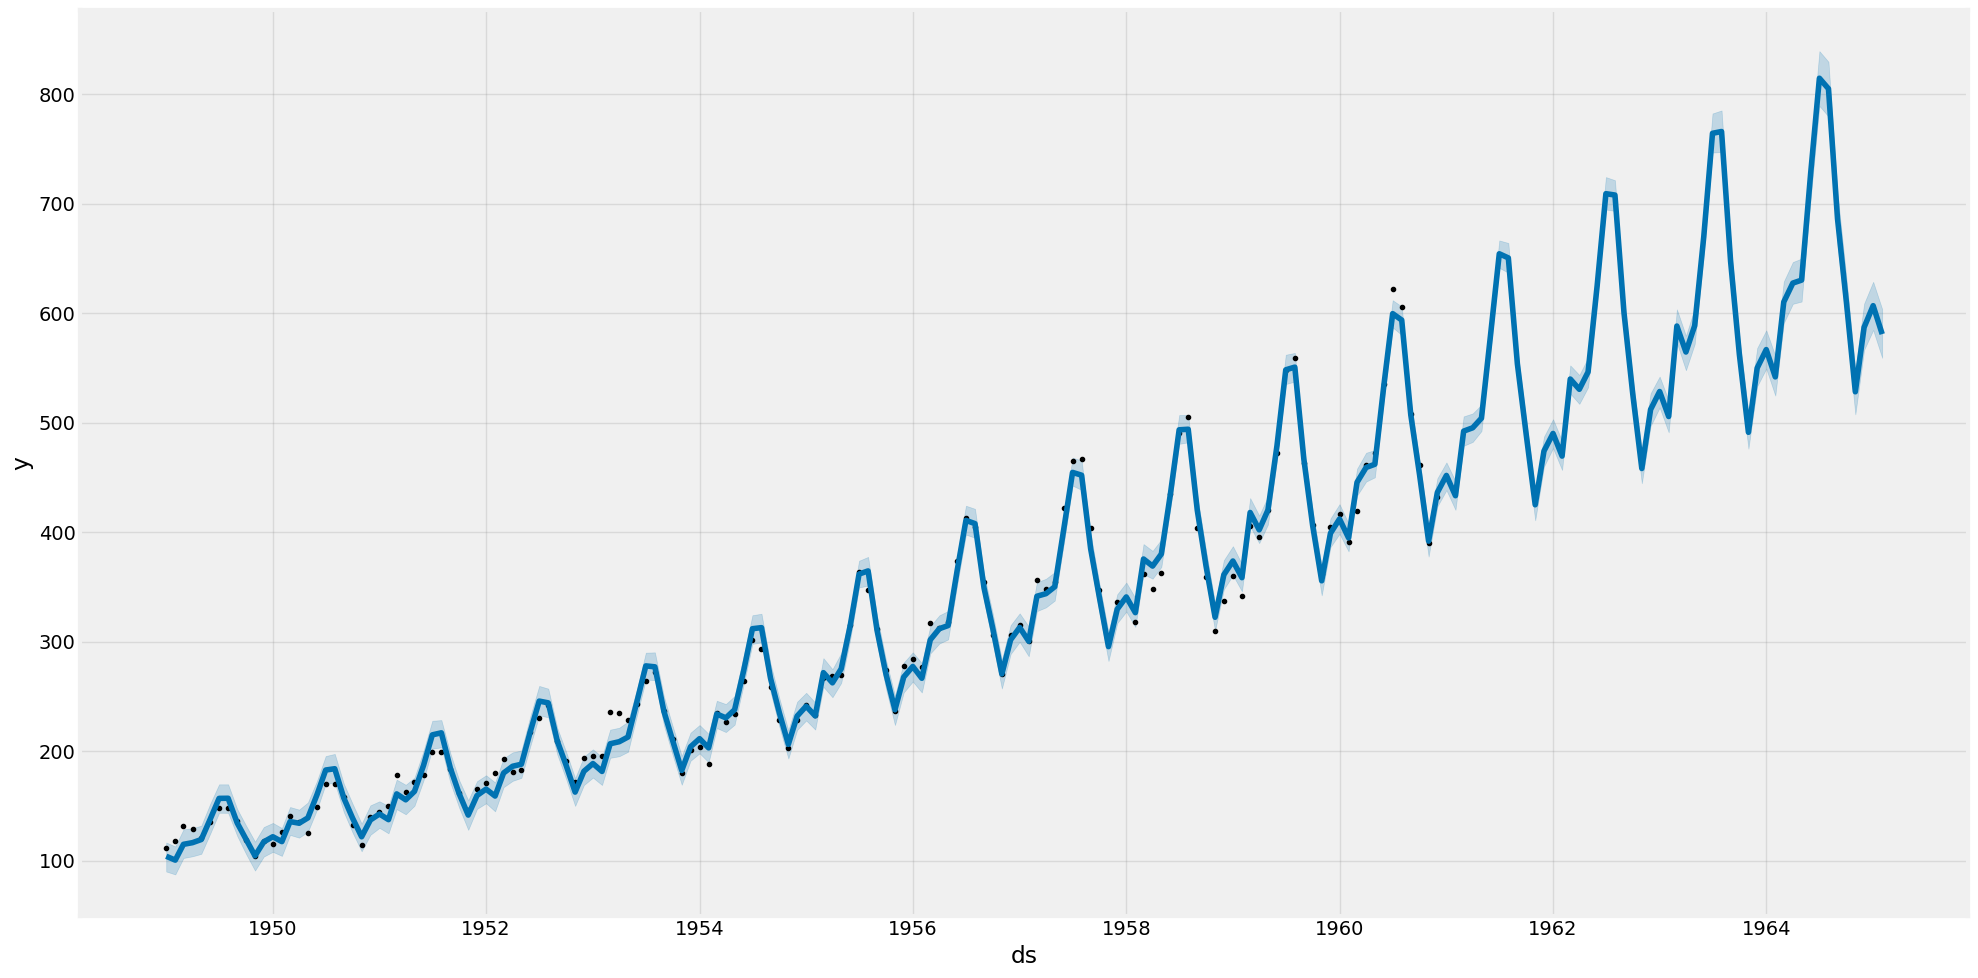

In [23]:
# we reduce the seasonality prior
m = Prophet(seasonality_mode ='multiplicative', seasonality_prior_scale = 1)
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

Last but not least, we can - as we usually ought to - use interval forecast, i.e. have our point estimates combined with uncertainty. By default the parameter mcmc_samples is set to 0, so to get the interval around seasonality, you must do full Bayesian sampling; uncertainty around trend can be calculated with Maximum A Posteriori (MAP) estimate.

13:27:56 - cmdstanpy - INFO - Chain [1] start processing
13:28:27 - cmdstanpy - INFO - Chain [1] done processing


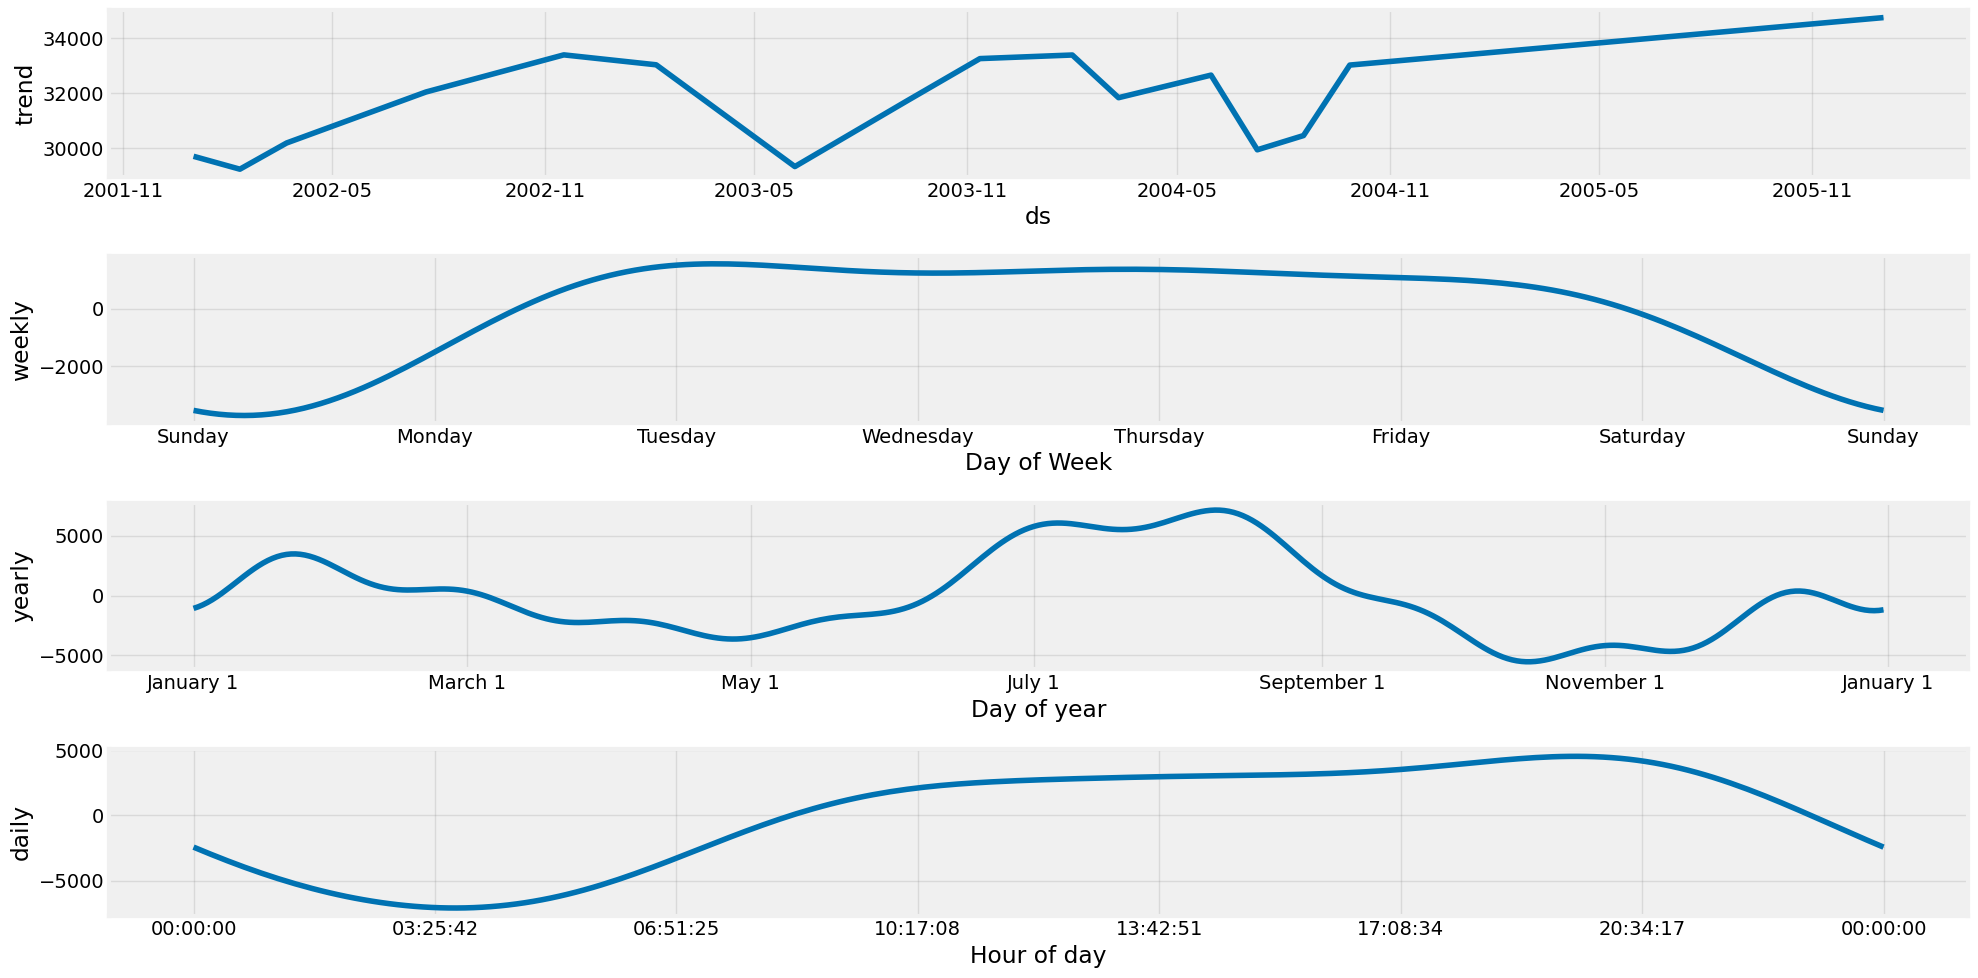

In [24]:
df = pd.read_csv(CFG.data_folder + 'hourly-energy-consumption/pjm_hourly_est.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
xdat = df[['Datetime', 'PJME']]
# trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={"Datetime": "ds", "PJME": "y"})
# xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2))

m = Prophet().fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods = 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

What if we switch to Bayesian inference (change mcmc_samples to a positive integer)?

13:28:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:28:35 - cmdstanpy - INFO - CmdStan done processing.
13:28:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lp

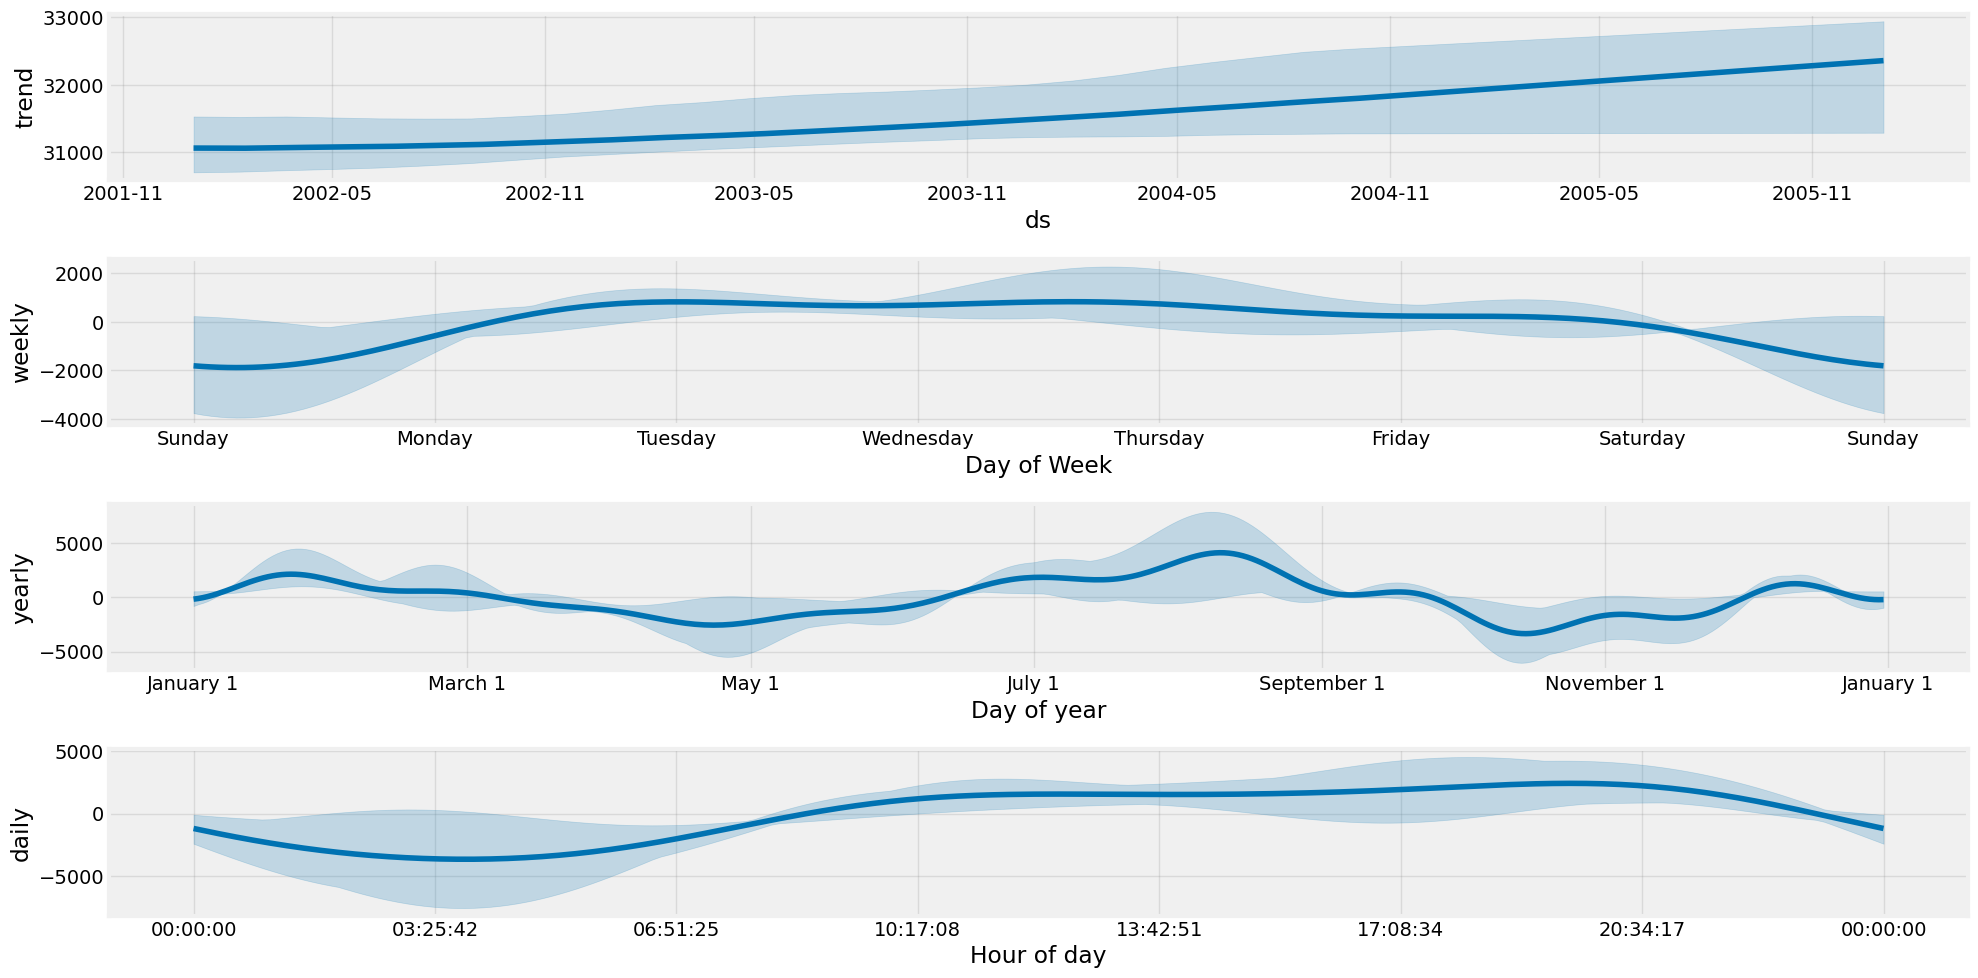

In [25]:
m = Prophet(mcmc_samples = 10).fit(xdat.iloc[:30000]) # bayesiano
future = m.make_future_dataframe(periods = 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

# Special days

So we have handled trend and seasonality - but that does not mean everything else belongs with the random error component. There are data points that are not random per se, but can still have impact on the performance of the model:

* public holidays (Christmas, Easter, New Year, Black Friday)
* special events (World Cup) 
* major events like conflict starting or terrorist attacks - when analyzing historical performance of the model, it is frequently useful to remove those
* outliers - this is something of a catch-all category, but frequently possible to identify by inspecting the data. 

The Prophet approach to modeling abnormal days is to provide a custom list of events. We assume the effects are independent, so if e.g. a sports event occurs near public holiday, their effects will be captured separately.

## Holidays

The dataset we will use to test the Prophet functionality around special days is daily count of bike commuters in Oslo

In [26]:
bikerides = pd.read_csv(CFG.data_folder + 'norway-bicycles/bikerides_day.csv', on_bad_lines='skip', encoding= 'unicode_escape', delimiter=',')
bikerides.head(5)
# the usual formatting
bikerides = bikerides[['Date', 'Volume']].rename(columns={"Date": "ds", "Volume": "y"})

We start with the fast and easy way of adding holidays: using the built-in list of country holidays:

In [27]:
m = Prophet()
m.add_country_holidays(country_name='NO') # anadir los festivos de Noruega
m.fit(bikerides) # ajustar la base de datos usando prophet
# List the holiday names
m.train_holiday_names

13:28:40 - cmdstanpy - INFO - Chain [1] start processing
13:28:40 - cmdstanpy - INFO - Chain [1] done processing


0              New Year's Day
1             Maundy Thursday
2                 Good Friday
3               Easter Sunday
4               Easter Monday
5                   Labor Day
6            Constitution Day
7               Ascension Day
8                 Whit Sunday
9                 Whit Monday
10              Christmas Day
11    Second Day of Christmas
dtype: object

I don't speak Norwegian, but a quick visit to Google Translate shows that Christmas is missing - which, in Europe, is typically a rather important public holiday. We will take care of adding it later, for now let's see how well the model is doing out of the box:

In [33]:
# as before, we create a dataframe holding the dates for the entire forecast horizon - 180 days ahead
future = m.make_future_dataframe(periods=180, freq='D')
# generate the actual forecast 
forecast = m.predict(future)

fig = go.Figure()
# full disclosure: I am changing the plotting style for this one, because I don't know how to overlay the two graphs with the baseline Prophet plotting functionality that served us well up to that point (not to mention the cool functionality of panning/scaling the graph ;-)

fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

Let's see if we can improve by augmenting the list of holidays: we do that by creating a new dataframe `christmas`, which is subsequently passed as an argument to Prophet. The 'holiday' entry is mostly for interpretation sake, relevant parts are:
* `ds` - so we know when the holiday of interest occurs
* `lower_window` and `upper_window`: those two parameters allow us to incorporate the effect before/after the date, respectively. In our example below `lower_window` equals -1, meaning we anticipate a drop in the number of commuters a day before Christmas, whereas `upper_window` is 7 - with a lot of people taking time off between Christmas and New Year, the bicycle traffic is likely to decrease for approximately a week.

In [34]:
# Anadir navidad
christmas = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2017-12-24','2018-12-24','2019-12-24','2020-12-24']),
  'lower_window': -1,
  'upper_window': 7,
})


m = Prophet(holidays=christmas)
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
forecast = m.predict(future)

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

13:31:30 - cmdstanpy - INFO - Chain [1] start processing
13:31:30 - cmdstanpy - INFO - Chain [1] done processing
